In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import logging

from models.cmiv_nn import regression_main, loss_func, prepro_args
from models.MerrorKIV.cmiv_k import *
from util import dotdict, fill_in_args, compute_rbf_kernel, cme_tuning, \
                make_psd, get_K, make_dotdict, fns
from general_util import get_median_inter_mnist


from models.MerrorKIV.trainer import get_median, MerrorKIVTrainer
from models.MerrorKIV.model import MerrorKIVModel
from data import generate_train_data, generate_test_data

### A simple DGP

In [2]:
custom1_design = {'name': 'custom1',
                  'N_data': 10000,
                  'noise_level': 0.,
                  'noise_level_merror': 1.,
                  'bias': 0.
}
custom1_design = dotdict(custom1_design)
custom1_design.fu = lambda N_data: 0.05*np.random.chisquare(10, size=N_data)
custom1_design.fz = lambda N_data: 0.5*np.random.chisquare(10, size=N_data)
custom1_design.fx = lambda z, u, N_data: 2 * np.log(u) + 0.1*z**2 + custom1_design.noise_level * np.random.normal(0, 1, N_data)
custom1_design.fy = lambda x, u, N_data: fns.sigmoid(x) + 0.*u + custom1_design.noise_level * np.random.normal(0,1, N_data)
custom1_design.fm = lambda x, N_data: x + custom1_design.noise_level_merror * np.random.normal(0,1, N_data)
custom1_design.fn = lambda x, N_data: x + custom1_design.noise_level_merror * np.random.normal(0,1, N_data) + custom1_design.bias



data_custom1 = sim(custom1_design)


NameError: name 'sim' is not defined

In [61]:
data_custom1.X[:10]

array([-0.92113715, -1.38297673, -0.4615449 ,  0.01506813,  3.71040191,
       -0.97136192,  2.3157409 , -0.28530199,  0.86964805,  0.60145745])

In [43]:
NP_design = {'name': 'NP',
                  'N_data': 10000,
                  'noise_level': 2.,
                  'noise_level_merror': 0.2,
                  'bias': 0.
}
NP_design = dotdict(NP_design)

NP_design.MU = np.zeros((3,))
NP_design.SIGMA = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])


NP_design.futw = lambda N_data: np.random.multivariate_normal(NP_design.MU, NP_design.SIGMA, size=N_data)
NP_design.fu = lambda N_data: NP_design.futw(N_data)[:, 0]
NP_design.fz = lambda N_data: stats.norm.cdf(NP_design.futw(N_data)[:, 2])
NP_design.fx = lambda z, u, N_data: stats.norm.cdf((NP_design.futw(N_data)[:, 1] + NP_design.futw(N_data)[:, 2]) / np.sqrt(2))
NP_design.fy = lambda x, u, N_data: np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5) + u
NP_design.fm = lambda x, N_data: x + NP_design.noise_level_merror * np.random.normal(0,1, N_data)
NP_design.fn = lambda x, N_data: x + NP_design.noise_level_merror * np.random.normal(0,1, N_data) + NP_design.bias

data_NP = sim(NP_design)



In [5]:


# set data

X, Y, Z, M, N, U = dt.X, dt.Y, dt.Z, dt.M, dt.N, dt.U

# plotting
sample_size = 200

D = pd.DataFrame([U[:sample_size], Z[:sample_size], X[:sample_size], M[:sample_size], N[:sample_size], Y[:sample_size]]).T
D.columns = ['U', 'Z', 'X','M', 'N', 'Y']
O = pd.DataFrame([Z[:sample_size], M[:sample_size], N[:sample_size], Y[:sample_size]]).T
O.columns = ['Z', 'M', 'N', 'Y']

ecorr_v = D.corr()
ecorr_v.columns = ['U', 'Z', 'X','M', 'N', 'Y']
ecorr_O = O.corr()
ecorr_O.columns = ['Z', 'M', 'N', 'Y']

for v in ['U', 'Z', 'X','M', 'N', 'Y']:
    sns.displot(D, x=v, label=v, kde=True), plt.show()

sns.set_theme(font="tahoma", font_scale=1)
plt.show()


sns.pairplot(D, height=1) 
sns.pairplot(O, height=1)
plt.show()

array([15.64328142, 21.88286127,  8.77257148,  5.30102697, 21.47295682,
       11.04627712,  9.21835263, 14.22444822, 23.60027477,  8.84871692])

In [6]:
N[:10]

array([17.45573181, 20.6403135 ,  3.71885935,  5.08168224, 20.74056621,
       11.3069041 ,  8.36148221, 13.41068838, 21.00418775,  8.87763954])

#### Now visualise Z wrt $\cos(\eta N)$ for different values of $\eta$.

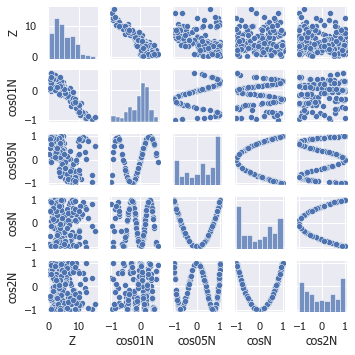

In [5]:
cos01N = np.cos(0.1*N)
cos05N = np.cos(0.5*N)
cosN = np.cos(N)
cos2N = np.cos(2*N)

ZCosEtaN = pd.DataFrame([Z[:sample_size], cos01N[:sample_size], cos05N[:sample_size], cosN[:sample_size], cos2N[:sample_size]]).T
ZCosEtaN.columns = ['Z', 'cos01N','cos05N', 'cosN', 'cos2N']

sns.pairplot(ZCosEtaN, height=1) 
plt.show()

### Try fitting $Me^{i\eta N}$ towards $Z$ for a few different values of $\eta$.

#### The data

In [15]:
# Mei01N = 2*Z
Mei01N = M * np.e**(0.1j*N)
Mei02N = M * np.e**(0.2j*N)
Mei1N = M * np.e**(1j*N)
Mei2N = M * np.e**(2j*N)

#### Regression implementation

In [16]:
N_train = 1000
train_data = np.concatenate([Mei01N.reshape(-1,1)[:N_train], Mei02N.reshape(-1,1)[:N_train], Mei1N.reshape(-1,1)[:N_train], Mei2N.reshape(-1,1)[:N_train], Z.reshape(-1,1)[:N_train]], axis=-1)

test_data = np.concatenate([Mei01N.reshape(-1,1)[N_train:], Mei02N.reshape(-1,1)[N_train:], Mei1N.reshape(-1,1)[N_train:], Mei2N.reshape(-1,1)[N_train:], Z.reshape(-1,1)[N_train:]], axis=-1)


In [24]:
regression_args = fill_in_args('configs/regression.yaml')

In [25]:
regression_args.train_data = train_data
regression_args.test_data = test_data

In [33]:
prepro_args(regression_args)
regression_args.num_points_to_visualize

500

number_of_basis_func:  4
train ep: 0/5
batch size = 64, train_data size = 1000 x 5
print first datum:  tensor([[3.5799+0.j],
        [4.4196+0.j],
        [4.6234+0.j],
        [2.9748+0.j],
        [0.4267+0.j]], dtype=torch.complex128)
[epoch 1, batch     1] loss: 0.004
print first datum:  tensor([[2.7707+0.j],
        [2.0806+0.j],
        [8.2247+0.j],
        [4.1686+0.j],
        [7.0402+0.j]], dtype=torch.complex128)
[epoch 1, batch     2] loss: 0.014
print first datum:  tensor([[2.7827+0.j],
        [7.2118+0.j],
        [4.5192+0.j],
        [3.2764+0.j],
        [2.5869+0.j]], dtype=torch.complex128)
[epoch 1, batch     3] loss: 0.002
print first datum:  tensor([[11.8137+0.j],
        [11.5946+0.j],
        [ 7.0934+0.j],
        [ 3.9551+0.j],
        [ 3.1642+0.j]], dtype=torch.complex128)
[epoch 1, batch     4] loss: 0.003
print first datum:  tensor([[5.6462+0.j],
        [1.1237+0.j],
        [8.9879+0.j],
        [3.6503+0.j],
        [2.4239+0.j]], dtype=torch.complex12

/Users/yuchenzhu/python_projects/ml/projects/measurement-error/miv/models/cmiv.py:95: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  preds = model(torch.Tensor(input_gt))[:args.num_points_to_visualize, pred_dim].detach().numpy()
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages

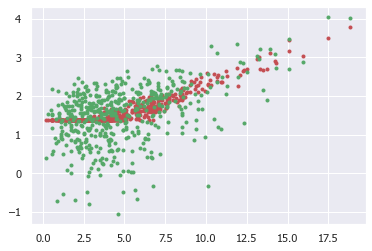

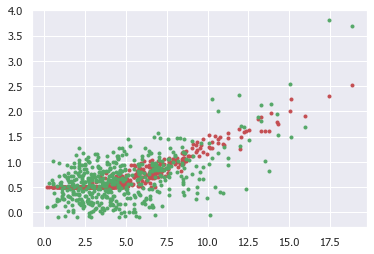

visualising dim 1


/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


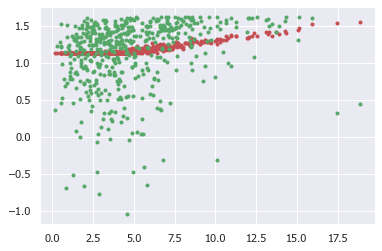

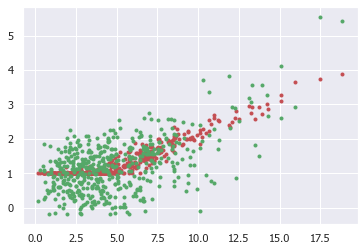

visualising dim 2


/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


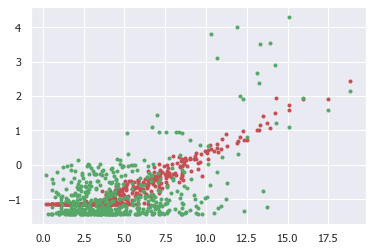

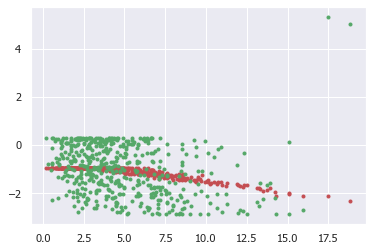

visualising dim 3


/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


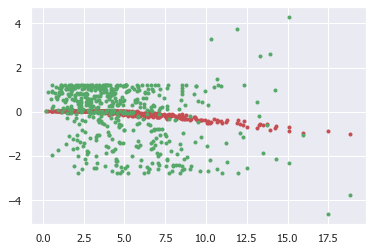

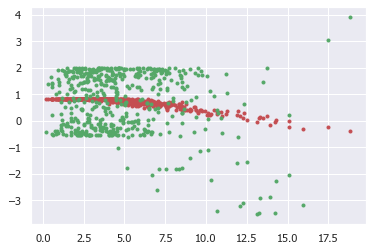

In [36]:
regression_main(regression_args)

In [53]:
%debug

> /Users/yuchenzhu/miniconda3/lib/python3.7/bdb.py(113)dispatch_line()
    111         if self.stop_here(frame) or self.break_here(frame):
    112             self.user_line(frame)
--> 113             if self.quitting: raise BdbQuit
    114         return self.trace_dispatch
    115 

ipdb> exit


In [31]:
x = torch.randn(2,2, dtype=torch.cfloat)

AttributeError: module 'torch' has no attribute 'cfloat'

In [12]:
a1 = torch.tensor([[1+1j, 3+3j], [2+2j, 4+4j]])
a2 = torch.tensor([[2+2j], [4+4j]])
a1_r = torch.view_as_real(a1)
a2_r = torch.view_as_real(a2)
print(a1_r)
print(a2_r)

torch.sum((a1_r - a2_r)**2, axis=-1)

tensor([[[1., 1.],
         [3., 3.]],

        [[2., 2.],
         [4., 4.]]])
tensor([[[2., 2.]],

        [[4., 4.]]])


tensor([[2., 2.],
        [8., 0.]])

### A kernel method

In [9]:
n_train, n_dev, n_test = 1000, 1000, 1000
train_data = np.concatenate([Z.reshape(-1,1)[:n_train], M.reshape(-1,1)[:n_train], N.reshape(-1,1)[:n_train]], axis=-1)
dev_data = np.concatenate([Z.reshape(-1,1)[n_train:n_train+n_dev], M.reshape(-1,1)[n_train:n_train+n_dev], N.reshape(-1,1)[n_train:n_train+n_dev]], axis=-1)
test_data = np.concatenate([Z.reshape(-1,1)[n_train+n_dev:n_train+n_dev+n_test], M.reshape(-1,1)[n_train+n_dev:n_train+n_dev+n_test], N.reshape(-1,1)[n_train+n_dev:n_train+n_dev+n_test]], axis=-1)

args = {}
args = dotdict(args)
args.n_train = n_train
args.n_dev = n_dev
# args.n_test = n_test
args.train = dotdict({})
args.train.all = train_data
args.train.Z = Z.reshape(-1,1)[:n_train]
args.train.M = M.reshape(-1,1)[:n_train]
args.train.N = N.reshape(-1,1)[:n_train]
args.train._X = X.reshape(-1,1)[:n_train]

args.dev = dotdict({})
args.dev.all = dev_data
args.dev.Z = Z.reshape(-1,1)[n_train:n_train+n_dev]
args.dev.M = M.reshape(-1,1)[n_train:n_train+n_dev]
args.dev.N = N.reshape(-1,1)[n_train:n_train+n_dev]
args.dev._X = X.reshape(-1,1)[n_train:n_train+n_dev]

args.test = dotdict({})
args.test.all = test_data
args.test.Z = Z.reshape(-1,1)[n_train+n_dev:n_train+n_dev+n_test]
args.test.M = M.reshape(-1,1)[n_train+n_dev:n_train+n_dev+n_test]
args.test.N = N.reshape(-1,1)[n_train+n_dev:n_train+n_dev+n_test]
args.test._X = X.reshape(-1,1)[n_train+n_dev:n_train+n_dev+n_test]

args.lambd_0 = np.log(0.05)




#### manual hyperparameter experiment

In [8]:
args.lambd_0

-2.995732273553991

In [13]:
from util import cme_loss

In [15]:
cme_loss(np.exp(-1), get_K(args), args)

0.16597247680666646

In [16]:
cme_loss(np.exp(-2), get_K(args), args)

0.1641536732159193

In [17]:
cme_loss(np.exp(-3), get_K(args), args)

0.1628838278230815

In [18]:
cme_loss(np.exp(-4), get_K(args), args)

0.1619871422345271

In [19]:
cme_loss(np.exp(-5), get_K(args), args)

0.16136409610216507

In [20]:
cme_loss(np.exp(-10), get_K(args), args)

0.15982255123185937

In [21]:
cme_loss(np.exp(-15), get_K(args), args)

0.15921918523122464

In [22]:
cme_loss(np.exp(-25), get_K(args), args)

0.1589432484945379

In [23]:
cme_loss(np.exp(-30), get_K(args), args)

0.15893795556902568

In [24]:
cme_loss(np.exp(-45), get_K(args), args)

0.15893393312192214

In [25]:
cme_loss(np.exp(-65), get_K(args), args)

0.15893393312192214

In [26]:
cme_loss(np.exp(-75), get_K(args), args)

0.15893393312192214

In [ ]:
cme_loss(np.exp(-45), get_K(args), args)

#### Hyperparameter tuning; visualise CME and char fun

In [12]:
cme_N = compute_cme(args, output='N')
cme_MN = compute_cme(args, output='MN')

1   [-2.89570502]   0.12836737104586354
2   [-2.67825885]   0.12818021448549077
3   [-2.18676412]   0.12798773694367285
Optimization terminated successfully.
         Current function value: 0.127988
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
1   [-2.89250353]   0.13040735871194217
2   [-2.6682631]   0.13020786501211024
3   [-2.1627299]   0.13000659256480868
Optimization terminated successfully.
         Current function value: 0.130007
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7


#### Validating $$\frac{\mathbb{E}[ Xe^{i\chi X}|Z]}{\mathbb{E}[e^{i\chi X}|Z]} = \frac{\mathbb{E}[Me^{i\chi N}|Z]}{\mathbb{E}[e^{i\chi N}|Z]}$$

In [17]:
args.train.Z.std()

4.263909770472261

In [46]:
size = 5
cme = cme_N
args = args
design = custom1_design

curly_x = np.linspace(-.5, .5, size).reshape(-1, 1)
#     z_vals = args.train.Z[np.random.choice(np.arange(args.n_train), size=size, replace=False)]
z_vals = np.linspace(args.train.Z.mean() - args.train.Z.std(), args.train.Z.mean() + args.train.Z.std(), size).reshape(-1,1)

K_Zz = compute_rbf_kernel(args.train.Z, z_vals, cme.K.sig_Z)
gamma = cme.brac_inv.dot(K_Zz)

ratio = dotdict({})

#############################
### regression quantities ###
#############################

ratio.regr = dotdict({})
ratio.regr.mn = dotdict({})
ratio.regr.x = dotdict({})

N_train = args.train.N
X_train = args.train._X

# denominators
cos_mn_term = np.cos(curly_x @ N_train.reshape(1, -1))
sin_mn_term = np.sin(curly_x @ N_train.reshape(1, -1))
ratio.regr.mn.denom = cos_mn_term.dot(gamma) + sin_mn_term.dot(gamma)*1j

cos_x_term = np.cos(curly_x @ X_train.reshape(1, -1))
sin_x_term = np.sin(curly_x @ X_train.reshape(1, -1))
ratio.regr.x.denom = cos_x_term.dot(gamma) + sin_x_term.dot(gamma)*1j

# numerators
ratio.regr.mn.numer = cos_mn_term.dot(gamma * args.train.M.reshape(-1, 1)) \
                    + sin_mn_term.dot(gamma * args.train.M.reshape(-1, 1))*1j

ratio.regr.x.numer = cos_x_term.dot(gamma * args.train._X.reshape(-1, 1)) \
                   + sin_x_term.dot(gamma * args.train._X.reshape(-1, 1))*1j

# ratios
ratio.regr.mn.value = ratio.regr.mn.numer / ratio.regr.mn.denom
ratio.regr.x.value = ratio.regr.x.numer / ratio.regr.x.denom

#############################
### sample quantities ###
#############################

ratio.sample = dotdict({})
ratio.sample.mn = dotdict({})
ratio.sample.x = dotdict({})

# evaluate the emipircal mean of the kernels by sampling. 
sample_size = 3000
ratio.sample.mn.denom = np.zeros((size, size))*1j
ratio.sample.mn.numer = np.zeros((size, size))*1j

ratio.sample.x.denom = np.zeros((size, size))*1j
ratio.sample.x.numer = np.zeros((size, size))*1j

for i, z_val in enumerate(z_vals):
    # regenerate a bunch of n by sampling
    u = design.fu(sample_size)
    z_val_reps = np.repeat(z_val, sample_size)
    x = design.fx(z_val_reps, u, sample_size)
    n = design.fn(x, sample_size)
    m = design.fm(x, sample_size)
    
    cos_mn_term = np.cos(curly_x @ n.reshape(1, -1))
    sin_mn_term = np.sin(curly_x @ n.reshape(1, -1))
    
    # denom mn
    ratio.sample.mn.denom[:, i] = np.mean(cos_mn_term, axis=1) + np.mean(sin_mn_term, axis=1)*1j
    # numer mn
    ratio.sample.mn.numer[:, i] = np.mean(cos_mn_term * m.reshape(1, -1), axis=1) + np.mean(sin_mn_term * m.reshape(1, -1), axis=1)*1j
    
    sample_mn_zi = ratio.sample.mn.numer[:, i] / ratio.sample.mn.denom[:, i]

    
    cos_x_term = np.cos(curly_x @ x.reshape(1, -1))
    sin_x_term = np.sin(curly_x @ x.reshape(1, -1))
    
    # denom mn
    ratio.sample.x.denom[:, i] = np.mean(cos_x_term, axis=1) + np.mean(sin_x_term, axis=1)*1j
    # numer mn
    ratio.sample.x.numer[:, i] = np.mean(cos_x_term * x.reshape(1, -1), axis=1) + np.mean(sin_x_term * x.reshape(1, -1), axis=1)*1j
    
    sample_x_zi = ratio.sample.x.numer[:, i] / ratio.sample.x.denom[:, i]
    
    

# ratios
ratio.sample.mn.value = ratio.sample.mn.numer / ratio.sample.mn.denom
ratio.sample.x.value = ratio.sample.x.numer / ratio.sample.x.denom

breakpoint()


# # do a heat map of both ehat_K_nN and e_K_nN
# f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)

# g1 = sns.heatmap(charhat_cos,cmap="YlGnBu",cbar=False,ax=ax1)
# g1.set_ylabel('$\mathcal{X}$')
# g1.set_xlabel('z')
# g1.set_title('$\hat{E}[cos(\mathcal{X}N)|z]$')

# g2 = sns.heatmap(char_cos,cmap="YlGnBu",cbar=False,ax=ax2) # e_K_xX = E[k(x, X)]
# g2.set_ylabel('$\mathcal{X}$')
# g2.set_xlabel('z')
# g2.set_title('$E[cos(\mathcal{X}N)|z]$')

# g3 = sns.heatmap(np.abs(char_cos - charhat_cos),cmap="YlGnBu",ax=ax3)
# g3.set_ylabel('$\mathcal{X}$')
# g3.set_xlabel('z')
# g3.set_title('diff')


--Call--
> /Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
-> def __call__(self, result=None):
(Pdb) ratio.sample.mn.value
*** NameError: name 'ratio' is not defined
(Pdb) up
> <ipython-input-46-e050d28b9789>(97)<module>()
-> breakpoint()
(Pdb) ratio.sample.mn.value
array([[ 7.60307847-2.32467785j, 10.74790046-2.56093336j,
        14.36306346-2.59643678j, 19.51363055-2.41400446j,
        24.91467178-2.57536806j],
       [ 7.69161504-1.16571204j, 10.65762292-1.24902924j,
        14.44786569-1.2671773j , 19.27461656-1.18443412j,
        24.78909489-1.23921217j],
       [ 7.69747288+0.j        , 10.66058264+0.j        ,
        14.46060089+0.j        , 19.19963072+0.j        ,
        24.76485667+0.j        ],
       [ 7.69161504+1.16571204j, 10.65762292+1.24902924j,
        14.44786569+1.2671773j , 19.27461656+1.18443412j,
        24.78909489+1.23921217j],
       [ 7.60307847+2.32467785j, 10.74790046+2.56093336j,
        14.36306346+2.59

BdbQuit: 

#### Validating cme

$E_N[k(n, N)|z]$ using samples, gives e

e_hat <k(n, .), \mu_n(z)>

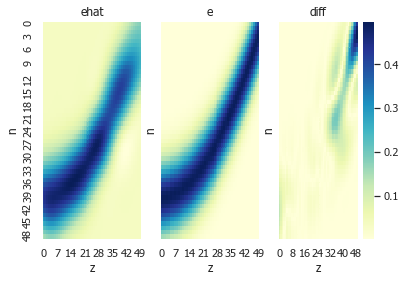

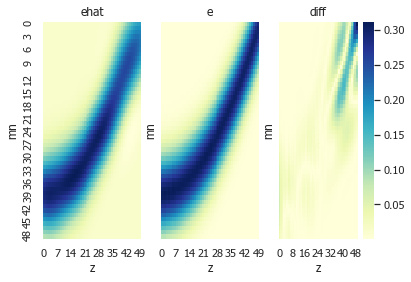

In [44]:
visualise_cme(size=50, target_vars='N', cme=all_args.stage_1.cme_N, args=all_args.stage_1, design=custom1_design)
visualise_cme(size=50, target_vars='MN', cme=all_args.stage_1.cme_MN, args=all_args.stage_1, design=custom1_design)


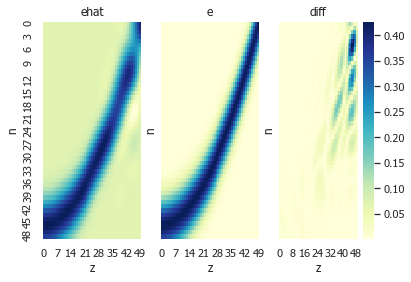

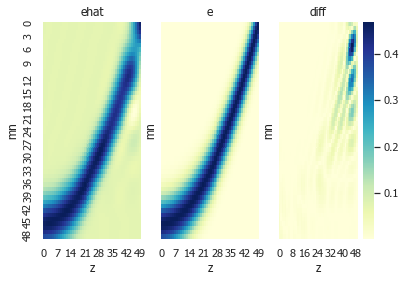

In [105]:
visualise_cme(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)
visualise_cme(size=50, target_vars='MN', cme=cme_MN, args=args, design=custom1_design)

#### Validating characteristic functions

$E[e^{i\chi N}|z]$

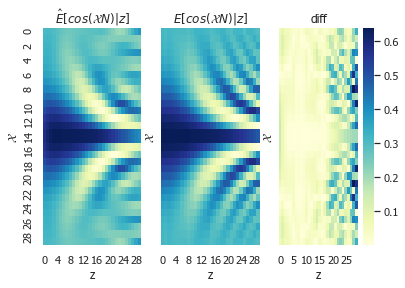

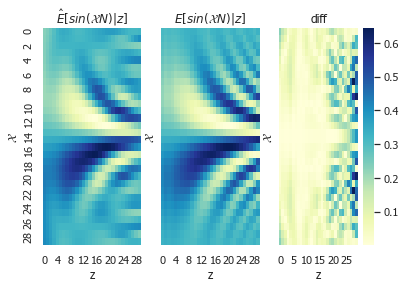

In [45]:
visualise_char_fun(size=30, target_vars='N', cme=all_args.stage_1.cme_N, args=all_args.stage_1, design=custom1_design)


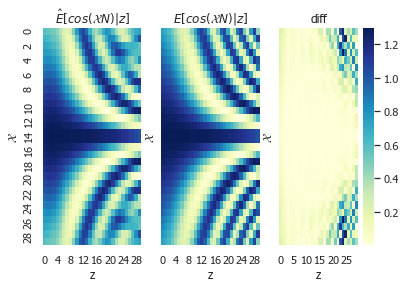

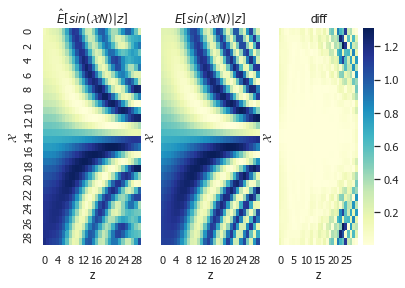

In [44]:
visualise_char_fun(size=30, target_vars='N', cme=cme_N, args=args, design=custom1_design)

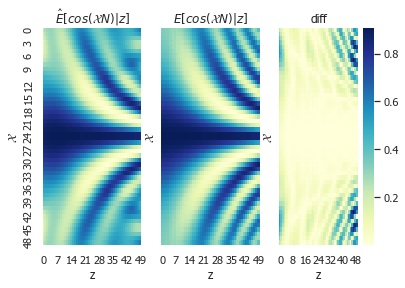

In [23]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

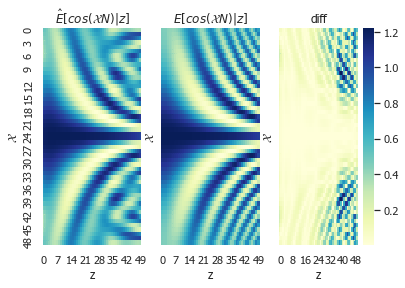

In [118]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

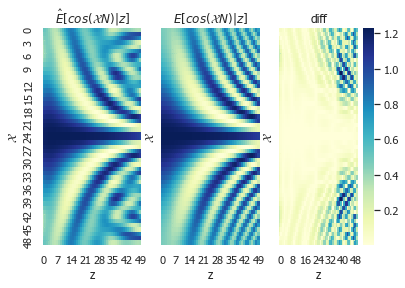

In [71]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

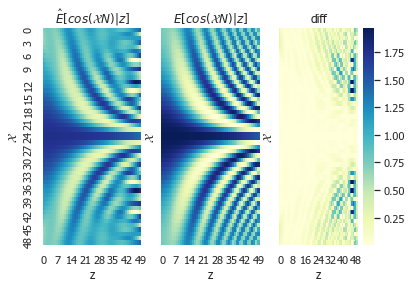

In [74]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

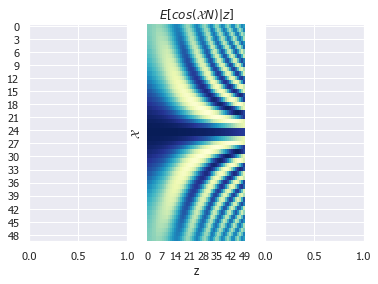

In [110]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

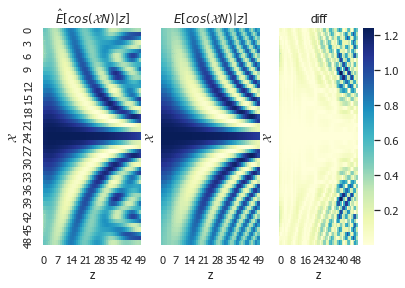

In [79]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

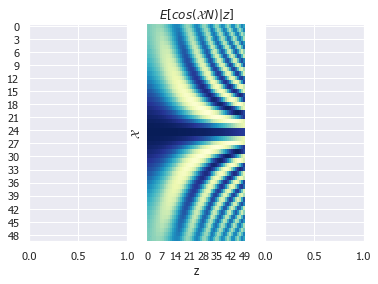

In [85]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

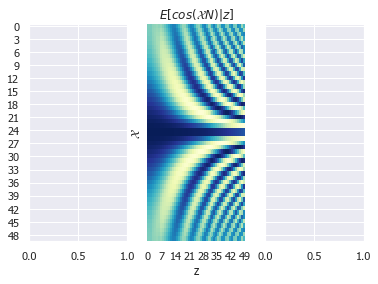

In [89]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

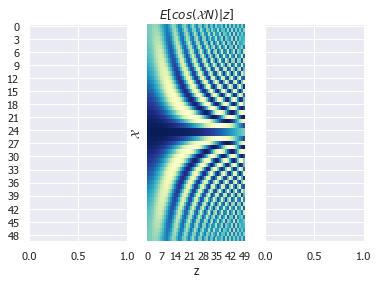

In [94]:
visualise_char_fun(size=50, target_vars='N', cme=cme_N, args=args, design=custom1_design)

#### Validating for specific values of $\chi$

##### using cme

#### Fourier transform of the kernel

We are using the RBF kernel in this paper:
$$
k(x) = \exp \left({-\frac{\|x\|^2}{2\sigma^2}}\right)
$$

The Fourier transform of a Gaussian function is still a Gaussian function, in this case specifically:
$$
\hat{k}(\chi) = \sqrt{2\pi\sigma^2}\exp \left( -2\pi^2\sigma^2 \|\chi\|^2 \right)
$$

In [82]:
def sample_from_khat(sample_size, sigma):
    samples = np.random.normal(0, 1, sample_size)
    samples = samples / 2 / np.pi / sigma
    return samples

samples = sample_from_khat(10000, 4.)
expected_std = 1/2/np.pi/4.

print(samples.std())
print(expected_std)


0.039849804084795264
0.039788735772973836


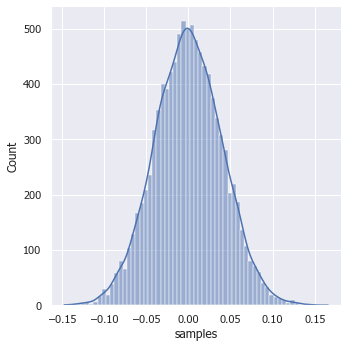

In [83]:
# plotting

D2 = pd.DataFrame([samples]).T
D2.columns = ['samples']

for v in ['samples']:
    sns.displot(D2, x=v, label=v, kde=True), plt.show()

sns.set_theme(font="tahoma", font_scale=1)
plt.show()

#### Stage 2 dataset

In [102]:
s2_data_args = dotdict({})
s2_data_args.chi_lim = [-0.5, 0.5]
s2_data_args.label_cutoff = 1.

In [103]:
import torch
from torch import tensor, optim

In [104]:
############################################
#### CREATE SUPERVISED LEARNING DATASET ####
############################################

# input: (n_chi, z) --> output: y
n_chi = 500
chi = np.linspace(s2_data_args.chi_lim[0], s2_data_args.chi_lim[1], n_chi).reshape(-1,1)

### gamma ###
K_Zz = compute_rbf_kernel(args.train.Z, args.dev.Z, cme_N.K.sig_Z)
gamma = cme_N.brac_inv.dot(K_Zz)
#############

### decompose e^{i\mathcal{X}n_i} ###
cos_term = np.cos(chi @ args.train.N.reshape(1, -1)) # shape: chi.shape[0] x args.train.N.shape[0] 
sin_term = np.sin(chi @ args.train.N.reshape(1, -1))
#####################################

### denominator ###
denom = dotdict({})
# using gamma to evaluate the charasteristic function value at a bunch of chi's
denom.cos_weighted = cos_term.dot(gamma) 
denom.sin_weighted = sin_term.dot(gamma)
denom.value = denom.cos_weighted + denom.sin_weighted*1j
###################

### numerator ###
numer = dotdict({})
numer.cos_weighted = cos_term.dot(gamma * args.train.M.reshape(-1, 1)) # shape: chi.shape[0] x args.dev.Z.shape[0] 
numer.sin_weighted = sin_term.dot(gamma * args.train.M.reshape(-1, 1)) 
numer.value = numer.cos_weighted + numer.sin_weighted*1j
#################

train_labels_ = numer.value / denom.value
train_labels = train_labels_.flatten().reshape(-1,1)



In [112]:
######################
### Curate dataset ###
######################

Y_real = np.real(train_labels).flatten()
Y_imag = np.imag(train_labels).flatten()

np.var(Y_real)
idx_select = (Y_real < np.mean(Y_real) + s2_data_args.label_cutoff*np.std(Y_real)) * (Y_real > np.mean(Y_real) - s2_data_args.label_cutoff*np.std(Y_real)) \
            * (Y_imag < np.mean(Y_imag) + s2_data_args.label_cutoff*np.std(Y_imag)) * (Y_imag > np.mean(Y_imag) - s2_data_args.label_cutoff*np.std(Y_imag)) 

train_labels = train_labels[idx_select]


chi_flat = np.repeat(chi, args.n_dev).reshape(-1,1)[idx_select]
z_dev_flat = np.repeat(args.dev.Z, n_chi, axis=1).T.flatten().reshape(-1,1)[idx_select]

# shuffle
data_idxes = np.arange(train_labels.shape[0])
np.random.shuffle(data_idxes)
train_labels = train_labels[data_idxes]
chi_flat = chi_flat[data_idxes]
z_dev_flat = z_dev_flat[data_idxes]


n_train2, n_dev2, n_test2 = 2000, 1000, 1000
train2_data = np.concatenate([z_dev_flat.reshape(-1,1)[:n_train2], chi_flat.reshape(-1,1)[:n_train2], train_labels.reshape(-1,1)[:n_train2]], axis=-1)
dev2_data = np.concatenate([z_dev_flat.reshape(-1,1)[n_train2:n_train2+n_dev2], chi_flat.reshape(-1,1)[n_train2:n_train2+n_dev2], train_labels.reshape(-1,1)[n_train2:n_train2+n_dev2]], axis=-1)
test2_data = np.concatenate([z_dev_flat.reshape(-1,1)[n_train2+n_dev2:n_train2+n_dev2+n_test2], chi_flat.reshape(-1,1)[n_train2+n_dev2:n_train2+n_dev2+n_test2], train_labels.reshape(-1,1)[n_train2+n_dev2:n_train2+n_dev2+n_test2]], axis=-1)


stage2_args = dotdict({})
stage2_args.n_train = n_train2
stage2_args.n_dev = n_dev2
stage2_args.n_test = n_test2

stage2_args.Z1 = tensor(args.train.Z)
stage2_args.N1 = tensor(args.train.N)
stage2_args.M1 = tensor(args.train.M)
stage2_args._X1 = tensor(args.train._X)
stage2_args.sig_Z1 = get_median_inter_mnist(args.train.Z)
stage2_args.cme_N = cme_N

stage2_args.train = dotdict({})
stage2_args.train.all = tensor(train2_data)
stage2_args.train.chi = tensor(chi_flat.reshape(-1,1)[:n_train2])
stage2_args.train.Z = tensor(z_dev_flat.reshape(-1,1)[:n_train2])
stage2_args.train.labels = tensor(train_labels.reshape(-1,1)[:n_train2])

stage2_args.dev = dotdict({})
stage2_args.dev.all = tensor(dev2_data)
stage2_args.dev.chi = tensor(chi_flat.reshape(-1,1)[n_train2:n_train2+n_dev2])
stage2_args.dev.Z = tensor(z_dev_flat.reshape(-1,1)[n_train2:n_train2+n_dev2])
stage2_args.dev.labels = tensor(train_labels.reshape(-1,1)[n_train2:n_train2+n_dev2])

# stage2_args.test = dotdict({})
# stage2_args.test.all = tensor(test2_data)
# stage2_args.test.chi = tensor(chi_flat.reshape(-1,1)[n_train2+n_dev2:n_train2+n_dev2+n_test2])
# stage2_args.test.Z = tensor(z_dev_flat.reshape(-1,1)[n_train2+n_dev2:n_train2+n_dev2+n_test2])
# stage2_args.test.labels = tensor(train_labels.reshape(-1,1)[n_train2+n_dev2:n_train2+n_dev2+n_test2])

stage2_args.reg_param = 0.*1e-3
stage2_args.batch_size = 64
stage2_args.lr = 0.001
stage2_args.num_epochs = 150



[autoreload of miv.util failed: Traceback (most recent call last):
  File "/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/yuchenzhu/miniconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/yuchenzhu/miniconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users

IndexError: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 481622

In [106]:
stage2_args.num_epochs = 200

In [107]:
stage2_args.dev.chi[:10]

tensor([[ 0.2295],
        [-0.1613],
        [-0.4920],
        [-0.2295],
        [ 0.2796],
        [-0.0671],
        [-0.4499],
        [ 0.0170],
        [ 0.4860],
        [ 0.4519]], dtype=torch.float64)

#### Visualise stage 2 dataset

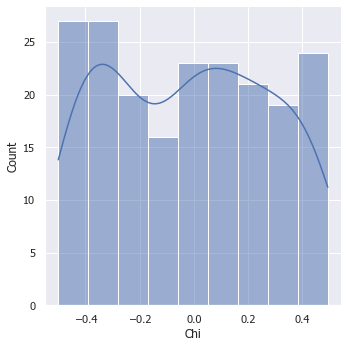

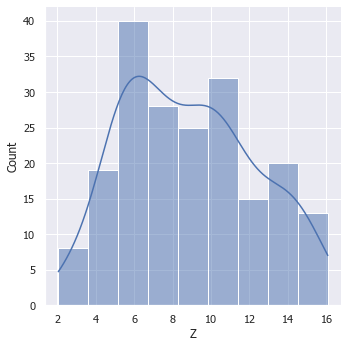

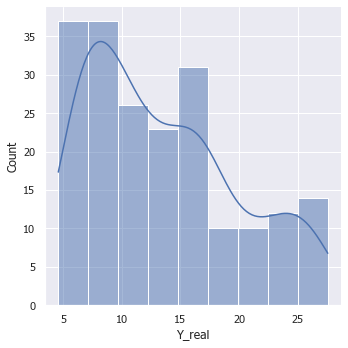

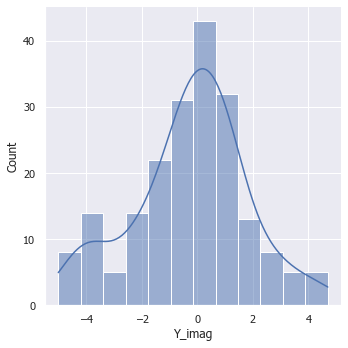

In [249]:
# plotting
sample_size = 200
stage2_args = all_args.stage_2
Chi_plot = stage2_args.train.Chi[:sample_size].numpy().flatten()
Z_plot = stage2_args.train.Z[:sample_size].numpy().flatten()
Y_real_plot = np.real(stage2_args.train.labels[:sample_size].numpy().flatten())
Y_imag_plot = np.imag(stage2_args.train.labels[:sample_size].numpy().flatten())


D2 = pd.DataFrame([Chi_plot, Z_plot, Y_real_plot, Y_imag_plot]).T
D2.columns = ['Chi','Z', 'Y_real', 'Y_imag']

ecorr_v = D2.corr()
ecorr_v.columns = ['Chi','Z', 'Y_real', 'Y_imag']


for v in ['Chi','Z', 'Y_real', 'Y_imag']:
    sns.displot(D2, x=v, label=v, kde=True), plt.show()

sns.set_theme(font="tahoma", font_scale=1)
plt.show()

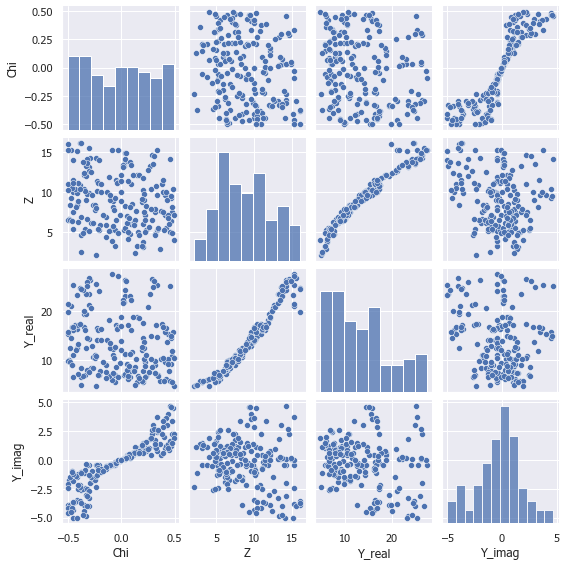

In [250]:
sns.pairplot(D2, height=2) 
plt.show()

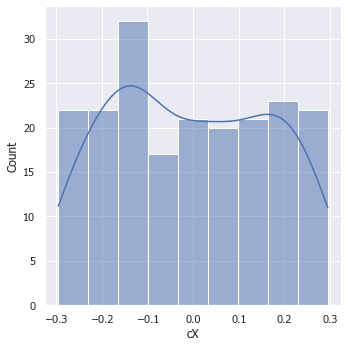

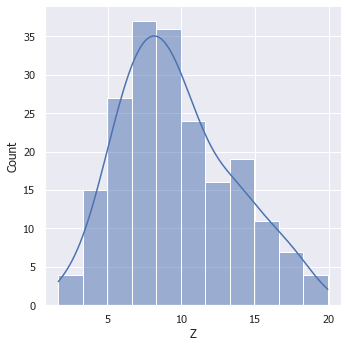

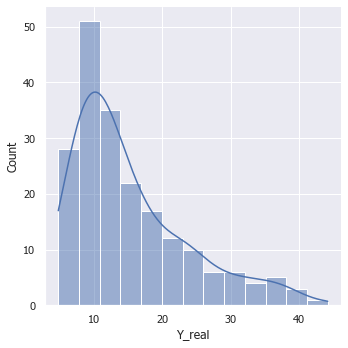

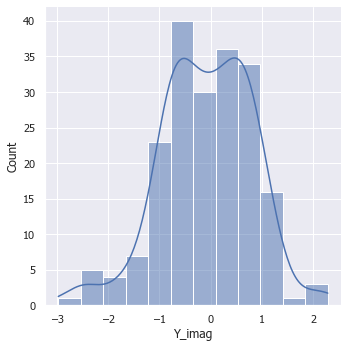

In [150]:
# plotting
sample_size = 200

chi_plot = stage2_args.train.chi[:sample_size].numpy().flatten()
Z_plot = stage2_args.train.Z[:sample_size].numpy().flatten()
Y_real_plot = np.real(stage2_args.train.labels[:sample_size].numpy().flatten())
Y_imag_plot = np.imag(stage2_args.train.labels[:sample_size].numpy().flatten())


D2 = pd.DataFrame([chi_plot, Z_plot, Y_real_plot, Y_imag_plot]).T
D2.columns = ['chi','Z', 'Y_real', 'Y_imag']

ecorr_v = D2.corr()
ecorr_v.columns = ['chi','Z', 'Y_real', 'Y_imag']


for v in ['chi','Z', 'Y_real', 'Y_imag']:
    sns.displot(D2, x=v, label=v, kde=True), plt.show()

sns.set_theme(font="tahoma", font_scale=1)
plt.show()

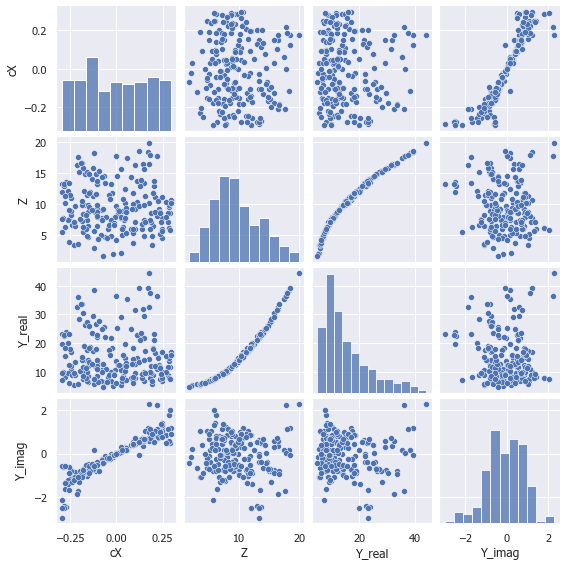

In [151]:
sns.pairplot(D2, height=2) 
plt.show()

#### Verify n bias

In [182]:
n_bias = 10.
### decompose e^{i\mathcal{X}n_i} ###
cos_term = np.cos(curly_x @ (args.train.N.reshape(1, -1)+n_bias)) # shape: curly_x.shape[0] x args.train.N.shape[0] 
sin_term = np.sin(curly_x @ (args.train.N.reshape(1, -1)+n_bias))
#####################################

### denominator ###
denom = dotdict({})
# using gamma to evaluate the charasteristic function value at a bunch of curly_x's
denom.cos_weighted = cos_term.dot(gamma) 
denom.sin_weighted = sin_term.dot(gamma)
denom.value = denom.cos_weighted + denom.sin_weighted*1j
###################

### numerator ###
numer = dotdict({})
numer.cos_weighted = cos_term.dot(gamma * args.train.M.reshape(-1, 1)) # shape: curly_x.shape[0] x args.dev.Z.shape[0] 
numer.sin_weighted = sin_term.dot(gamma * args.train.M.reshape(-1, 1)) 
numer.value = numer.cos_weighted + numer.sin_weighted*1j
#################

train_labels_ = numer.value / denom.value
train_labels = train_labels_.flatten().reshape(-1,1)


Y_real = np.real(train_labels).flatten()
Y_imag = np.imag(train_labels).flatten()

np.var(Y_real)
idx_select = (Y_real < np.mean(Y_real) + s2_data_args.Y_cutoff*np.var(Y_real)) * (Y_real > np.mean(Y_real) - s2_data_args.Y_cutoff*np.var(Y_real)) \
            * (Y_imag < np.mean(Y_imag) + s2_data_args.Y_cutoff*np.var(Y_imag)) * (Y_imag > np.mean(Y_imag) - s2_data_args.Y_cutoff*np.var(Y_imag)) 

train_labels = train_labels[idx_select]

In [144]:
np.array([1,2,3])[[True, False, False]]

array([1])

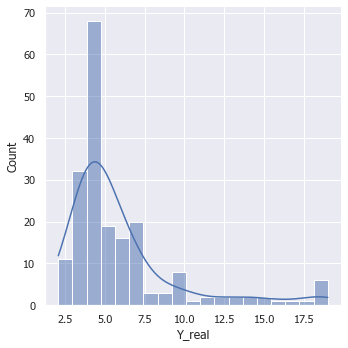

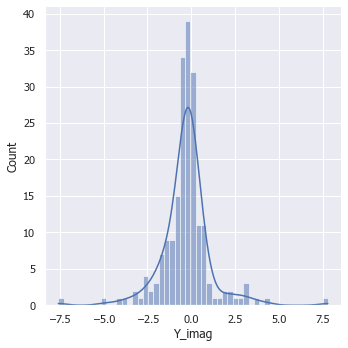

In [183]:
# plotting
sample_size = 200

Y_real_ = np.real(train_labels.flatten())
Y_imag_ = np.imag(train_labels.flatten())

D_ = pd.DataFrame([Y_real_[:sample_size], Y_imag_[:sample_size]]).T
D_.columns = ['Y_real', 'Y_imag']

ecorr_v = D_.corr()
ecorr_v.columns = ['Y_real', 'Y_imag']


for v in ['Y_real', 'Y_imag']:
    sns.displot(D_, x=v, label=v, kde=True), plt.show()

sns.set_theme(font="tahoma", font_scale=1)
plt.show()

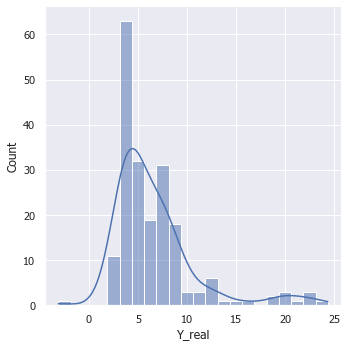

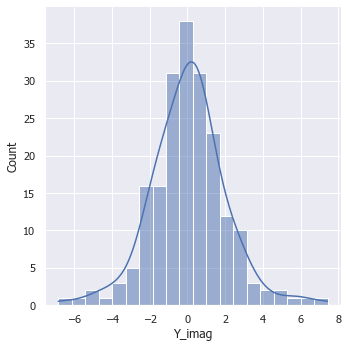

In [181]:
# plotting
sample_size = 200

Y_real_ = np.real(train_labels.flatten())
Y_imag_ = np.imag(train_labels.flatten())

D_ = pd.DataFrame([Y_real_[:sample_size], Y_imag_[:sample_size]]).T
D_.columns = ['Y_real', 'Y_imag']

ecorr_v = D_.corr()
ecorr_v.columns = ['Y_real', 'Y_imag']


for v in ['Y_real', 'Y_imag']:
    sns.displot(D_, x=v, label=v, kde=True), plt.show()

sns.set_theme(font="tahoma", font_scale=1)
plt.show()

#### Stage 2 model

In [8]:
fitted_x = stage_two_main(stage2_args)
print(fitted_x[:10], '\n', stage2_args._X1[:10])

NameError: name 'stage2_args' is not defined

In [15]:
fitted_x = stage_two_out.fitted_x
print((np.sum((fitted_x - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((all_args.stage_2.N1.numpy()- all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((all_args.stage_2.M1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((1/2 * all_args.stage_2.M1.numpy() + 1/2 * all_args.stage_2.N1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))



0.3021656797904522
0.7343627850360646
0.7142370432004507
0.5021275221344819


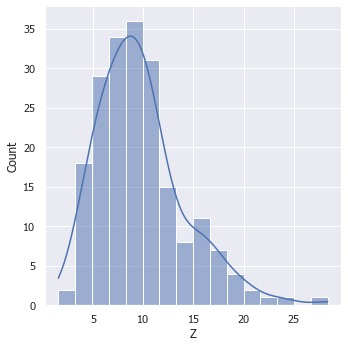

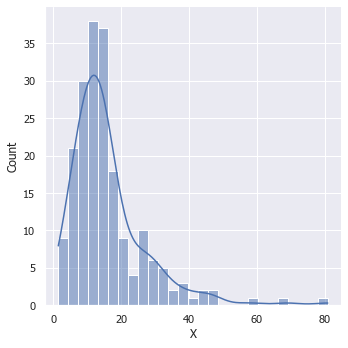

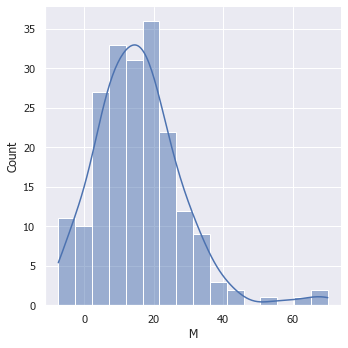

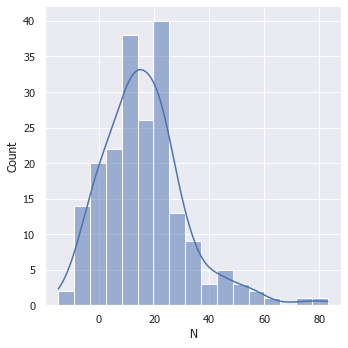

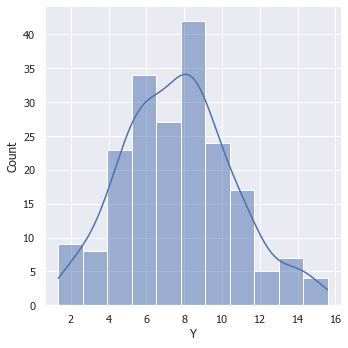

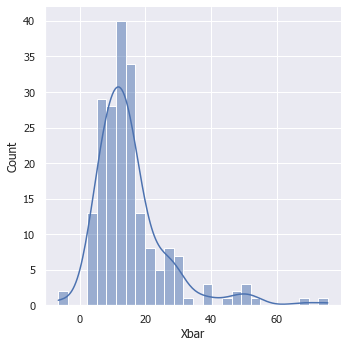

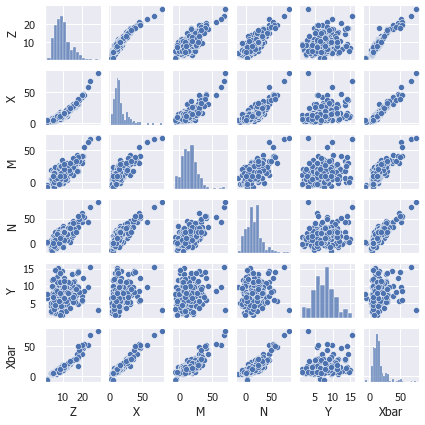

In [20]:
# plotting
sample_size = 200

D = pd.DataFrame([all_args.stage_1.train.Z[:sample_size].flatten(), 
                  all_args.stage_1.train._X[:sample_size].flatten(), 
                  all_args.stage_1.train.M[:sample_size].flatten(), 
                  all_args.stage_1.train.N[:sample_size].flatten(), 
                  all_args.stage_1.train.Y[:sample_size].flatten(), 
                  fitted_x[:sample_size].flatten()]).T
D.columns = ['Z', 'X','M', 'N', 'Y', 'Xbar']

ecorr_v = D.corr()
ecorr_v.columns = ['Z', 'X','M', 'N', 'Y', 'Xbar']

for v in ['Z', 'X','M', 'N', 'Y', 'Xbar']:
    sns.displot(D, x=v, label=v, kde=True), plt.show()

sns.set_theme(font="tahoma", font_scale=1)
plt.show()

sns.pairplot(D, height=1) 
plt.show()

In [30]:
np.std(all_args.stage_2._X1.numpy())

10.968744026655079

In [86]:
stage2_args.M1.shape

torch.Size([1000, 1])

In [42]:
%debug

> /Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/torch/_tensor.py(678)__array__()
    676             return handle_torch_function(Tensor.__array__, (self,), self, dtype=dtype)
    677         if dtype is None:
--> 678             return self.numpy()
    679         else:
    680             return self.numpy().astype(dtype, copy=False)

ipdb> up
> <ipython-input-40-097dc556cd1a>(27)forward()
     25         denom = dotdict({})
     26         # using gamma to evaluate the charasteristic function value at a bunch of curly_x's
---> 27         denom.cos_weighted = torch.sum(cos_term * gamma.T, dim=-1).reshape(-1,1)
     28         denom.sin_weighted = torch.sum(sin_term * gamma.T, dim=-1).reshape(-1,1)
     29         denom.value = denom.cos_weighted + denom.sin_weighted*1j

ipdb> gamma.T
array([[-0.0014046 ,  0.00704581, -0.0015109 , ..., -0.00131181,
        -0.00076097, -0.00079528],
       [ 0.00080648,  0.01117294, -0.00031719, ..., -0.00059529,
        -0.00106209,  0.0010

In [ ]:
def train(model, args):
    model.train()
    
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    
    for ep in range(args.num_epochs):
        batches_data = split_into_batches(data)
        for i, batch_data in enumerate(batches_data):
            batch_data_input, batch_data_output = batch_data[:, -1:], batch_data[:, :-1]
            preds = model(batch_data_input)
            loss = args.loss_func(preds, batch_data_output)
            
            optimiser.zero_grad()
            
            loss.backward()
            optimizer.step()
    return model

def split_into_batches(data):
    pass

args = {'loss_func': torch.MSEloss}

#### Stage 3: estimating causal effect using KIV

### Main function

1. Learn the CME for both N|Z and M,N|Z (i.e. $\lambda_n$ and $\lambda_{mn}$).
2. Use the right hand side of the equation to construct the stage 2 labels for each $\chi$ and $z$.
3. Learn the corresponding $x$'s and $\lambda_x$.
4. Use KIV stage 2 to learn $\xi$.
5. Predict Y and visualise.

In [13]:
from designs import datasets
# set data
dt = datasets.NP  # NP, custom1, HLLT

print(dt.keys())

dict_keys(['data', 'design'])


In [14]:
print(dt.data.X[:10,0])
print(all_args.stage_1.train._X[:10, 0])

[0.97738097 0.53001856 0.87909737 0.64058787 0.22199079 0.71275535
 0.02278771 0.73372385 0.32542541 0.0879954 ]


NameError: name 'all_args' is not defined

In [15]:
dt.data.keys()

dict_keys(['X', 'Y', 'Z', 'M', 'N', 'U'])

In [16]:
# dt.data['Z'] = dt.data.Z[:,0:1]
dt.data['Z'].shape

(10000, 1)

X is latent.

U is latent.



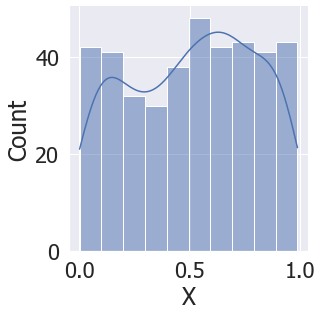

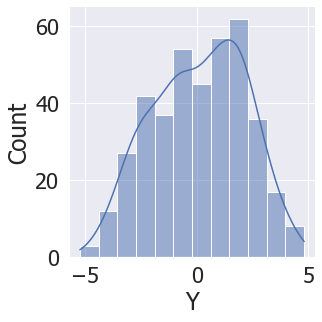

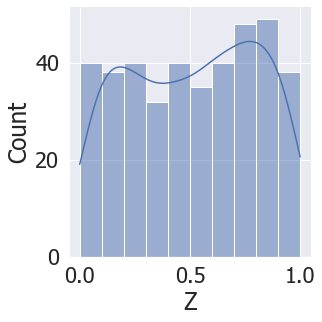

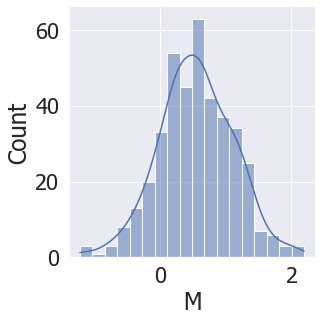

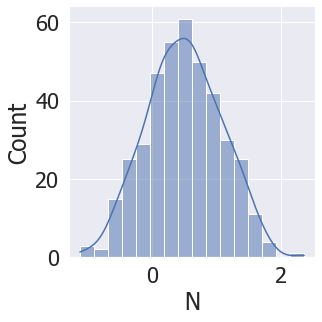

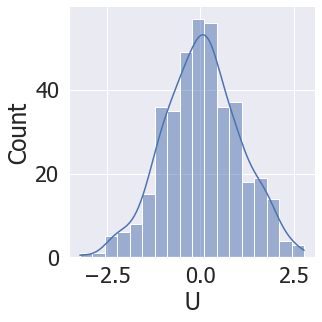

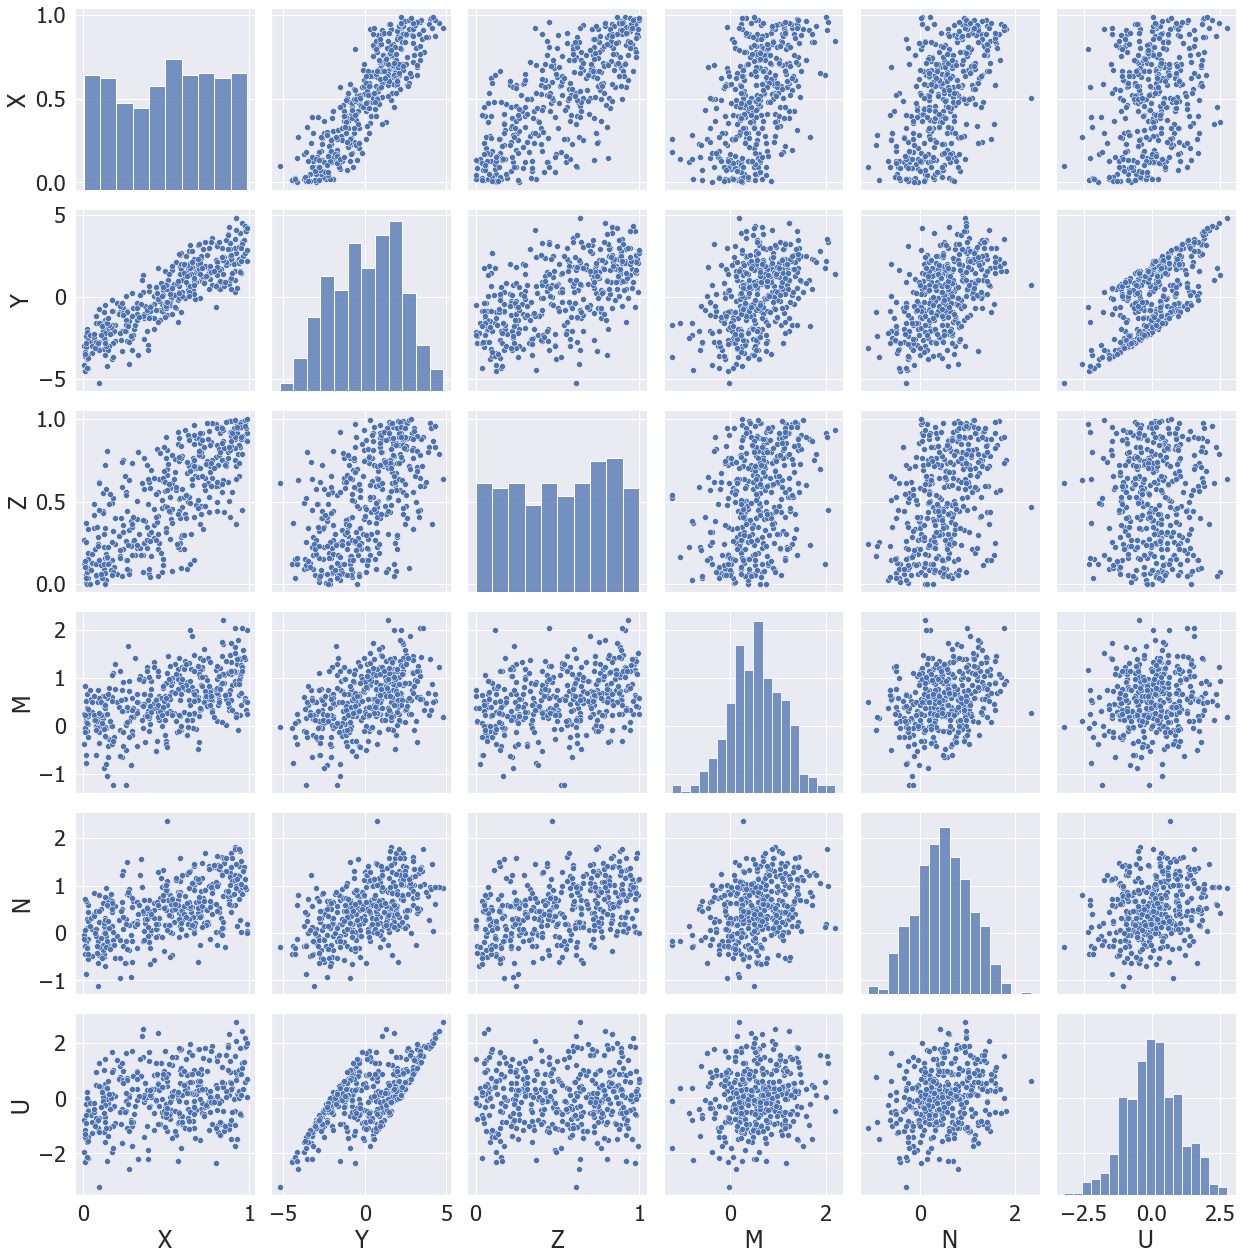

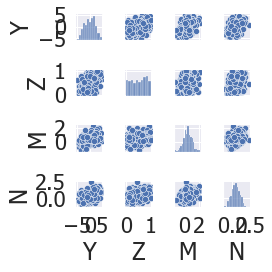

In [18]:
from util import visualise_dataset
visualise_dataset(dt.data, sample_size=400, observed_keys=['Z', 'X1', 'X2', 'M', 'N', 'Y'])



In [4]:
##########
## main ##
##########

start = time.time()
raw_sim = dt

all_args = fill_in_args('../configs/kernel.yaml')


In [20]:
%debug

> <ipython-input-13-07ce5189352d>(1)<module>()
----> 1 print((np.sum((fitted_x - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
      2 print((np.sum((all_args.stage_2.N1.numpy()- all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
      3 print((np.sum((all_args.stage_2.M1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
      4 print((np.sum((1/2 * all_args.stage_2.M1.numpy() + 1/2 * all_args.stage_2.N1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))

ipdb> 
ipdb> 
ipdb> exit


In [5]:
# load data
prepare_pre_stage_1_args_and_data(all_args, raw_sim)


In [6]:
# Stage 1
prepare_stage_1_data_and_args(all_args)
compute_cme_s1_main(all_args)


1   [-3.24199477]   0.4163698595698303
2   [-3.82805459]   0.41287139573443915
3   [-4.34288121]   0.41138042414178116
4   [-4.87069848]   0.4106243513482051
5   [-5.35223322]   0.41029627681471187
6   [-5.77757423]   0.4101632249423319
7   [-6.10692775]   0.41011967394504417
Optimization terminated successfully.
         Current function value: 0.410120
         Iterations: 7
         Function evaluations: 30
         Gradient evaluations: 10
1   [-3.23271374]   0.3971006284862077
2   [-3.79908285]   0.3939102487934461
3   [-4.2710087]   0.3926350780435148
4   [-4.76841556]   0.39196288929395573
5   [-5.2308812]   0.39166210624669917
6   [-5.65034157]   0.39153547912828923
7   [-5.97803779]   0.39149349534403677
Optimization terminated successfully.
         Current function value: 0.391493
         Iterations: 7
         Function evaluations: 30
         Gradient evaluations: 10


In [7]:
# Stage 2
raw_data2 = create_stage_2_raw_data(all_args)
prepare_stage_2_data_and_args(all_args, raw_data2)


In [8]:
all_args.stage_2.num_epochs = 200

In [9]:
start = time.time()
stage_two_out = stage_two_main(all_args.stage_2) # need to 1. add hyperparameter tuning routine, 2. also tune for lambda_x
end = time.time()
print(end - start)

first 10 M:  tensor([[ 0.3143],
        [ 1.2486],
        [ 0.0068],
        [ 1.3599],
        [ 1.0155],
        [-1.0515],
        [ 0.2670],
        [ 1.2423],
        [ 0.1093],
        [ 1.0977]], dtype=torch.float64)
first 10 N:  tensor([[ 0.8797],
        [ 1.0048],
        [ 0.4753],
        [ 2.3284],
        [ 0.0696],
        [-0.2960],
        [ 0.5893],
        [ 0.7495],
        [ 0.1518],
        [ 0.9317]], dtype=torch.float64)
first 10 _X:  tensor([[0.6059],
        [0.9373],
        [0.7628],
        [0.8812],
        [0.0339],
        [0.1879],
        [0.1554],
        [0.9265],
        [0.0027],
        [0.3795]], dtype=torch.float64)
first 10 initialised:  tensor([[ 0.5970],
        [ 1.1267],
        [ 0.2410],
        [ 1.8442],
        [ 0.5426],
        [-0.6738],
        [ 0.4282],
        [ 0.9959],
        [ 0.1305],
        [ 1.0147]], dtype=torch.float64, grad_fn=<SliceBackward0>)
num train data:  2000


/Users/yuchenzhu/python_projects/ml/projects/measurement-error/miv/models/MerrorKIV/cmiv_k.py:308: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.nn.Parameter((torch.tensor(args.M1) + torch.tensor(args.N1)) / 2)


[epoch 1, batch     1] loss: 0.00106, mse: 0.00106, reg: 0.00000
[epoch 1, batch     2] loss: 0.00490, mse: 0.00490, reg: 0.00000
[epoch 1, batch     3] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch     4] loss: 0.00236, mse: 0.00236, reg: 0.00000
[epoch 1, batch     5] loss: 0.00265, mse: 0.00265, reg: 0.00000
[epoch 1, batch     6] loss: 0.00151, mse: 0.00151, reg: 0.00000
[epoch 1, batch     7] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 1, batch     8] loss: 0.00077, mse: 0.00077, reg: 0.00000
[epoch 1, batch     9] loss: 0.00184, mse: 0.00184, reg: 0.00000
[epoch 1, batch    10] loss: 0.00133, mse: 0.00133, reg: 0.00000
[epoch 1, batch    11] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 1, batch    12] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 1, batch    13] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch    14] loss: 0.00074, mse: 0.00074, reg: 0.00000
[epoch 1, batch    15] loss: 0.00091, mse: 0.00091, reg: 0.00000
[epoch 1, batch    16] lo

In [12]:
stage_two_out.fitted_x[:10]

array([[ 0.67781625],
       [ 0.89497876],
       [ 1.02963325],
       [-0.04212882],
       [ 0.95463737],
       [ 0.33970441],
       [ 0.31449919],
       [ 0.55144332],
       [ 0.92149607],
       [ 0.56903342]])

In [11]:
# fitted_x = model.x.detach().numpy()
# fitted_x[:10]
fitted_x = stage_two_out.fitted_x

In [14]:
all_args.stage_2.train.labels[:10]

tensor([[0.4056-0.0062j],
        [0.5747-0.0162j],
        [0.6203+0.0055j],
        [0.3906-0.0227j],
        [0.5344+0.0027j],
        [0.4198+0.0134j],
        [0.5497+0.0043j],
        [0.6005-0.0074j],
        [0.6477-0.0197j],
        [0.4679-0.0099j]], dtype=torch.complex128)

In [12]:
print((np.sum((fitted_x - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((all_args.stage_2.N1.numpy()- all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((all_args.stage_2.M1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((1/2 * all_args.stage_2.M1.numpy() + 1/2 * all_args.stage_2.N1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))


0.8317053644713412
1.7405838675584115
1.6942691428698327
1.1838654324440219


In [25]:
print((np.sum((fitted_x - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((all_args.stage_2.N1.numpy()- all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((all_args.stage_2.M1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
print((np.sum((1/2 * all_args.stage_2.M1.numpy() + 1/2 * all_args.stage_2.N1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))



0.8641815824148368
2.5825714835847364
2.576163863739042
1.8285357449862023


In [38]:
print(all_args.train.M[:10])
print(all_args.train._X[:10])

[[-3.98899179]
 [ 0.06456131]
 [ 2.39647192]
 [ 1.205708  ]
 [ 3.68877791]
 [ 1.62372296]
 [-6.17326445]
 [-8.14614972]
 [ 0.37278424]
 [ 6.28263277]]
[[-1.33113598]
 [-2.49756864]
 [-1.81256862]
 [ 1.07514531]
 [ 0.21734352]
 [ 0.56184168]
 [-1.70177523]
 [-3.18216012]
 [ 1.63340309]
 [ 1.92160714]]


In [44]:
def vis_fitted_x(stage_two_out, all_args):
    fitted_x = stage_two_out.fitted_x
    print((np.sum((fitted_x - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
    print((np.sum((all_args.stage_2.N1.numpy()- all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
    print((np.sum((all_args.stage_2.M1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))
    print((np.sum((1/2 * all_args.stage_2.M1.numpy() + 1/2 * all_args.stage_2.N1.numpy() - all_args.stage_2._X1.numpy())**2) / fitted_x.shape[0])**0.5 / np.std(all_args.stage_2._X1.numpy()))

    # plotting
    sample_size = 200

    D = pd.DataFrame([all_args.stage_1.train.Z[:sample_size].flatten(), 
                      all_args.stage_1.train._X[:sample_size].flatten(), 
                      all_args.stage_1.train.M[:sample_size].flatten(), 
                      all_args.stage_1.train.N[:sample_size].flatten(), 
                      all_args.stage_1.train.Y[:sample_size].flatten(), 
                      fitted_x[:sample_size].flatten()]).T
    D.columns = ['Z', 'X','M', 'N', 'Y', 'Xbar']

    ecorr_v = D.corr()
    ecorr_v.columns = ['Z', 'X','M', 'N', 'Y', 'Xbar']

    for v in ['Z', 'X','M', 'N', 'Y', 'Xbar']:
        sns.displot(D, x=v, label=v, kde=True), plt.show()

    sns.set_theme(font="tahoma", font_scale=1)
    plt.show()

    sns.pairplot(D, height=1) 
    plt.show()




0.14784026913768517
1.7471621091490377
1.7609223349246892
1.2304949425877945


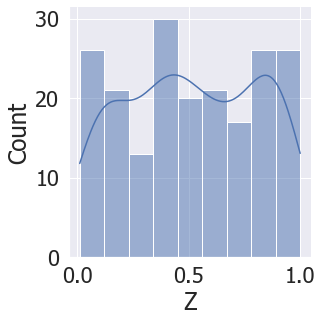

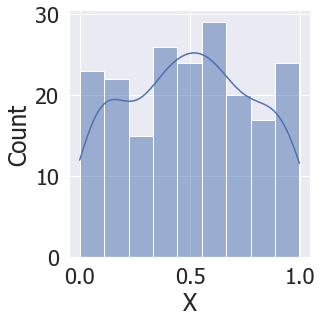

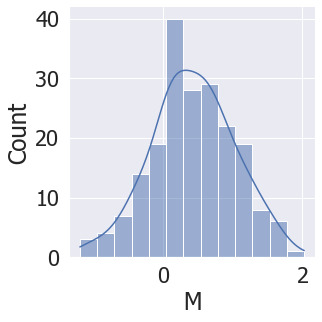

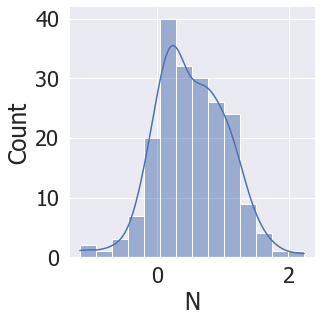

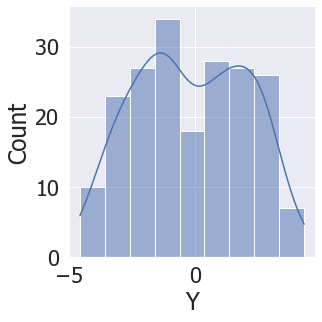

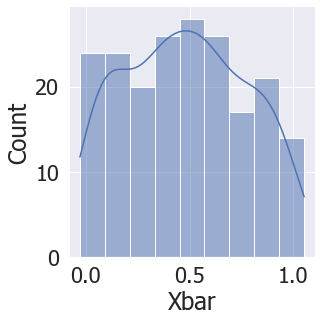

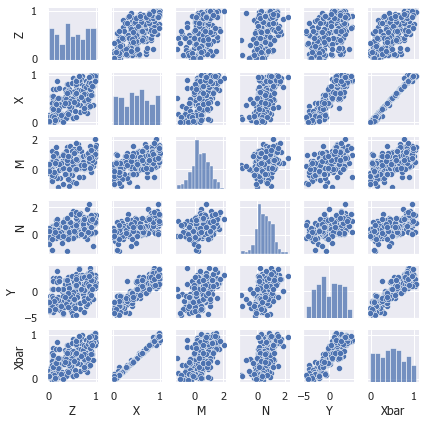

In [45]:
vis_fitted_x(stage_two_out, all_args)

0.7541281792670721
1.3658902972225122
1.3482275080733692
0.9667093444850544


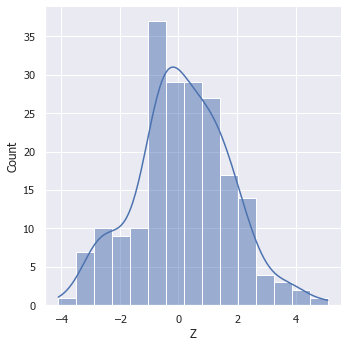

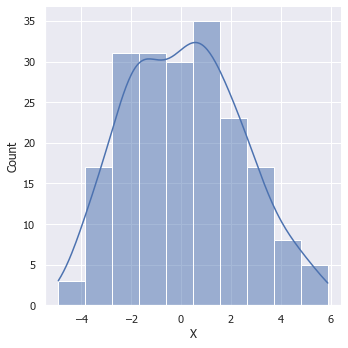

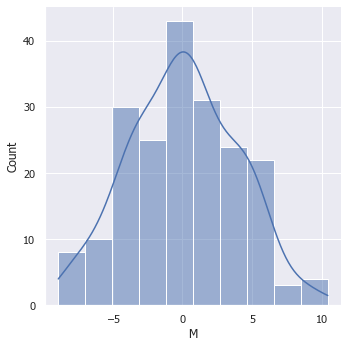

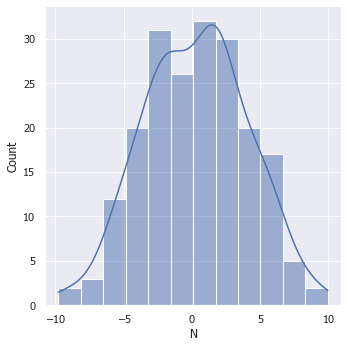

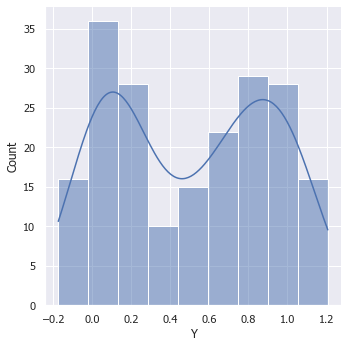

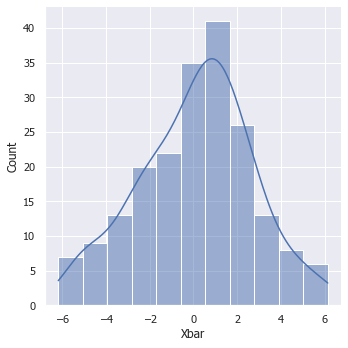

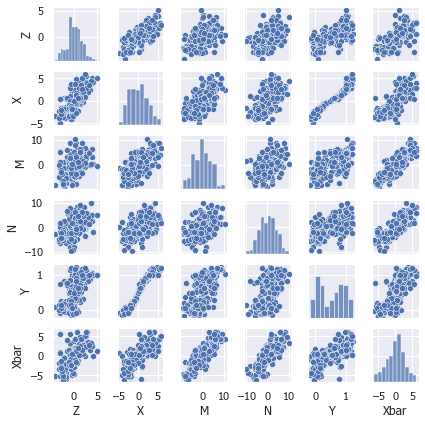

In [7]:
vis_fitted_x(stage_two_out, all_args)

0.5788151204415944
1.7122894182161648
1.8571217219983096
1.2543239248534306


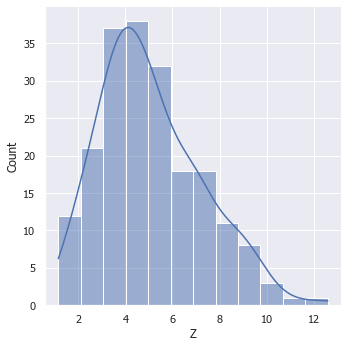

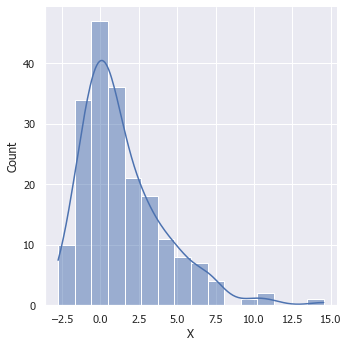

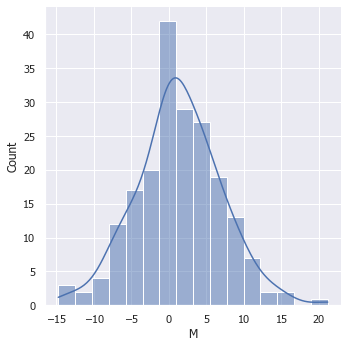

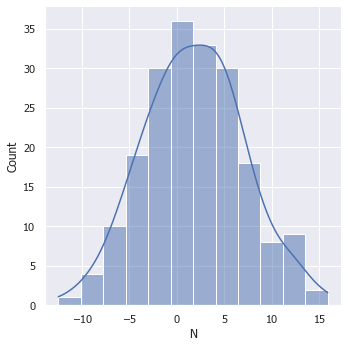

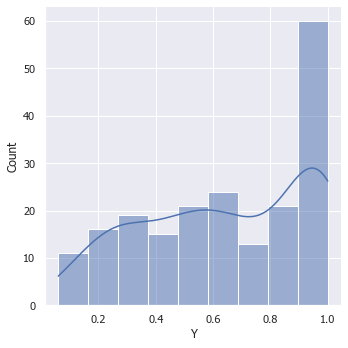

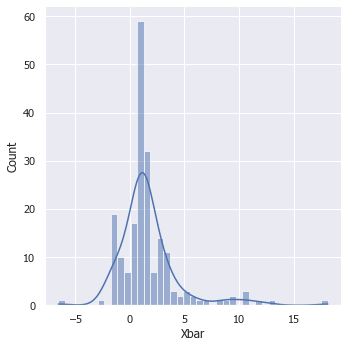

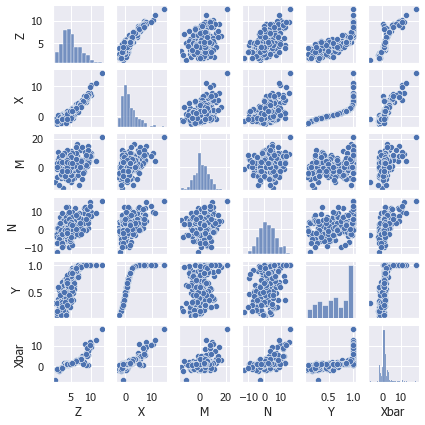

In [118]:
vis_fitted_x(stage_two_out, all_args)

0.5785744646715176
1.7122894182161648
1.8571217219983096
1.2543239248534306


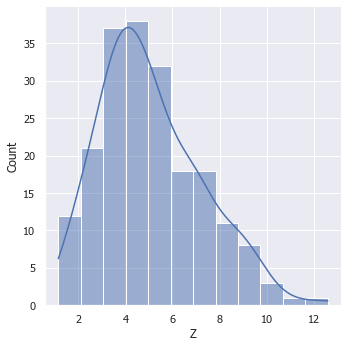

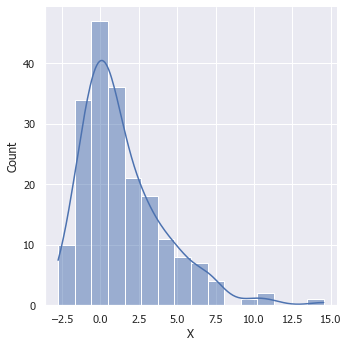

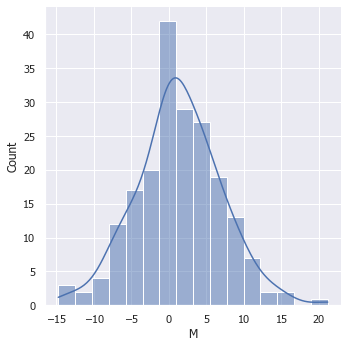

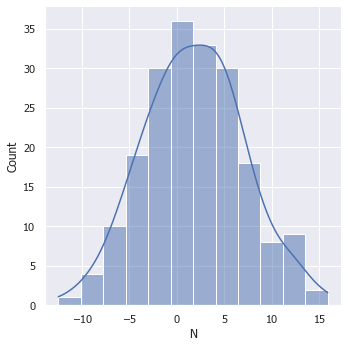

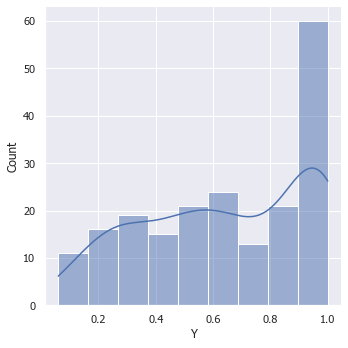

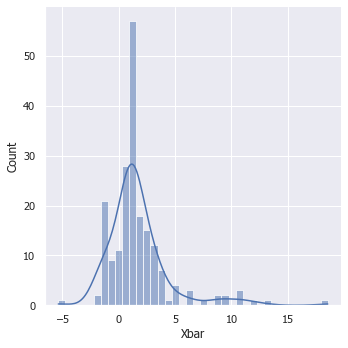

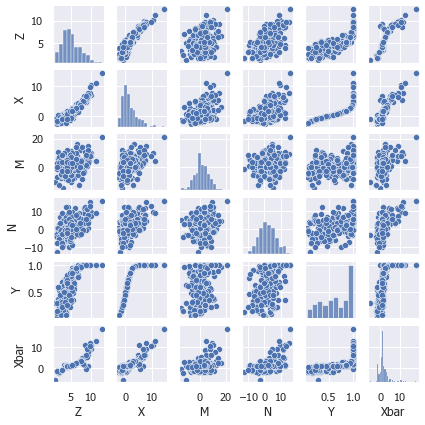

In [115]:
vis_fitted_x(stage_two_out, all_args)

0.5948683014409679
1.7122894182161648
1.8571217219983096
1.2543239248534306


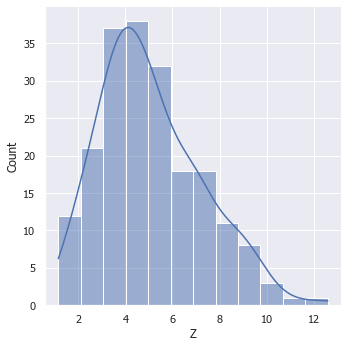

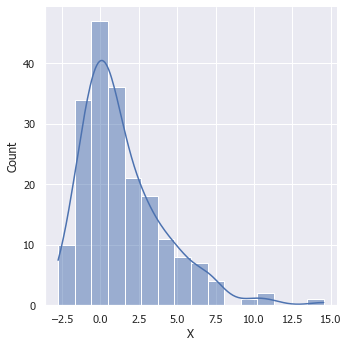

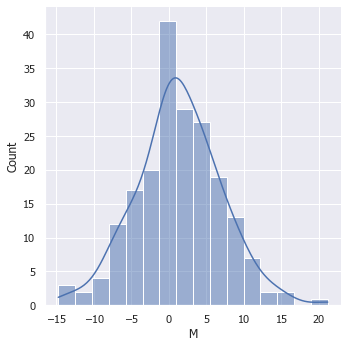

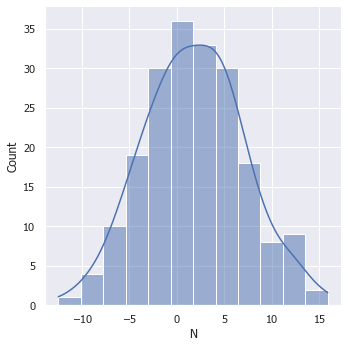

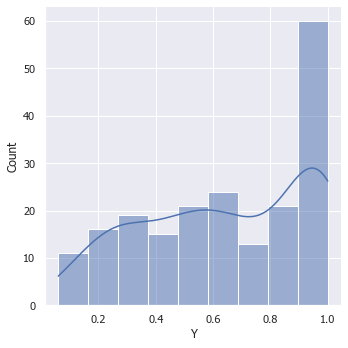

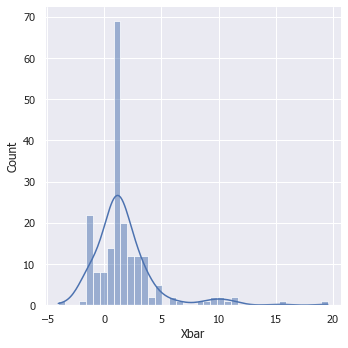

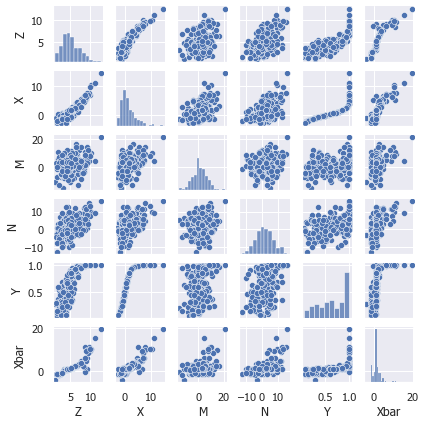

In [112]:
vis_fitted_x(stage_two_out, all_args)

0.6861751887602918
1.7122894182161648
1.8571217219983096
1.2543239248534306


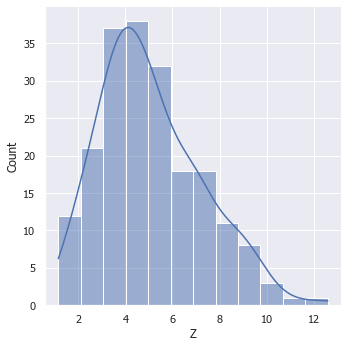

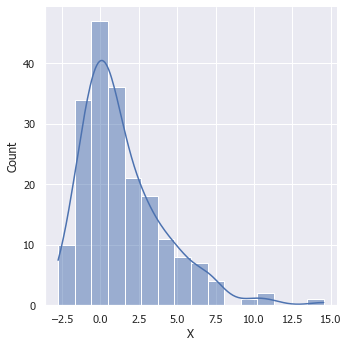

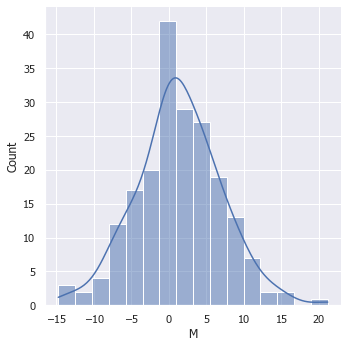

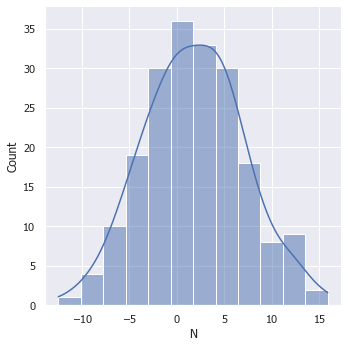

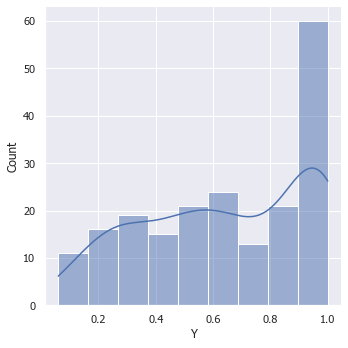

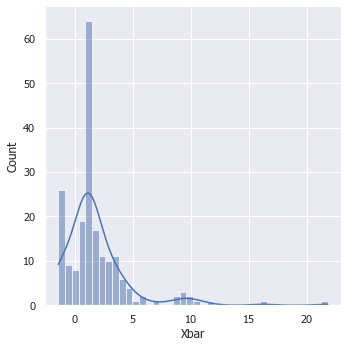

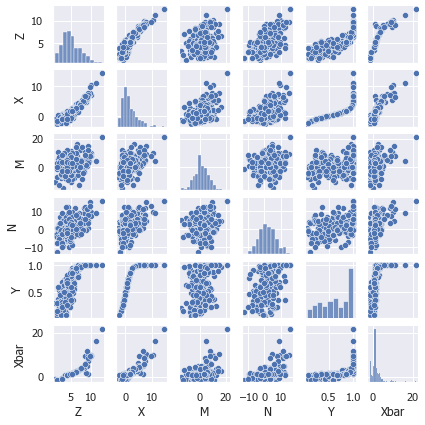

In [102]:
vis_fitted_x(stage_two_out, all_args)

0.1491046305485395
0.7153840135842982
0.6813695237555643
0.501283651801743


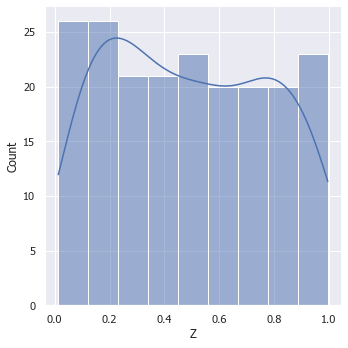

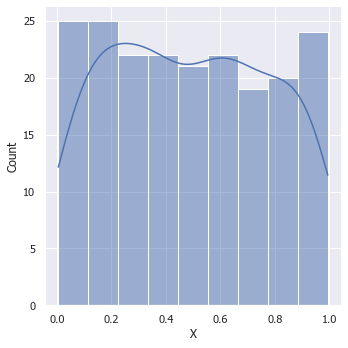

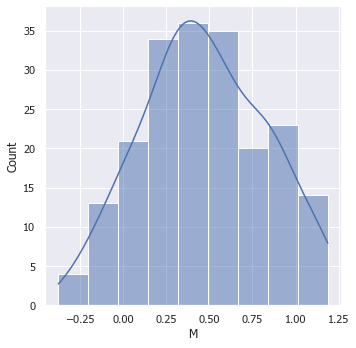

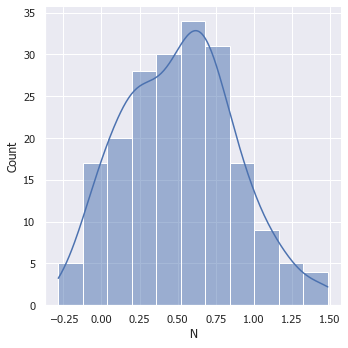

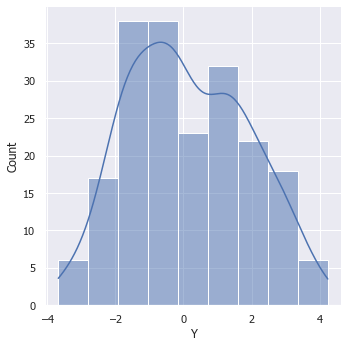

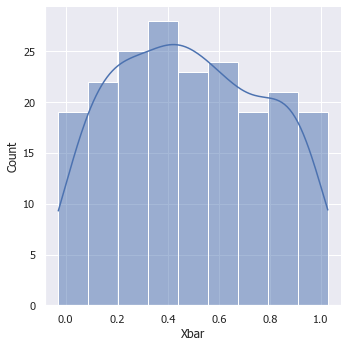

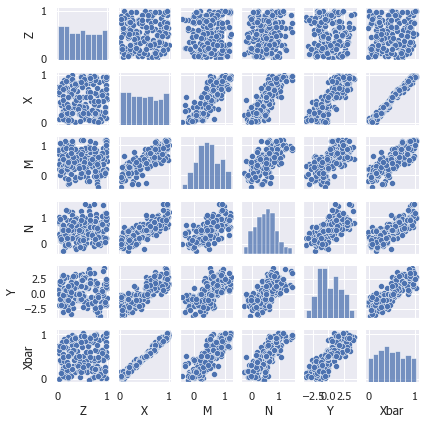

In [61]:
vis_fitted_x(stage_two_out, all_args)

0.2979069974250156
0.695057348686221
0.684322261719984
0.4995165192690757


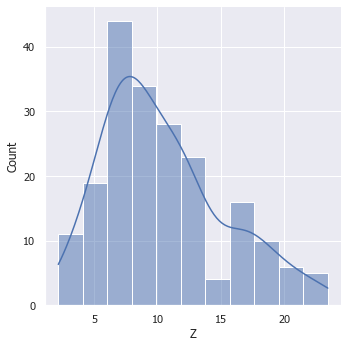

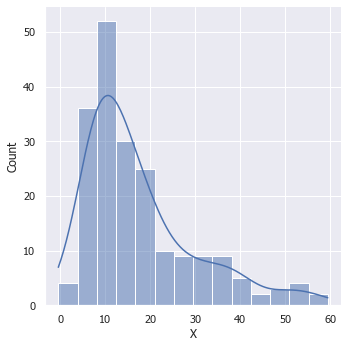

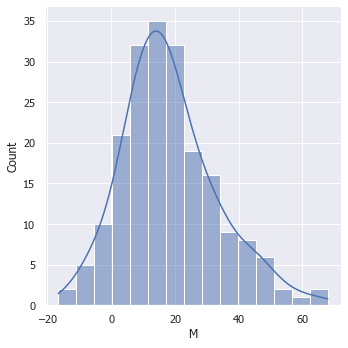

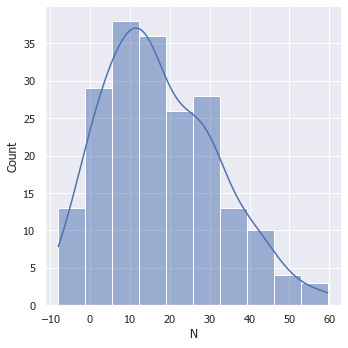

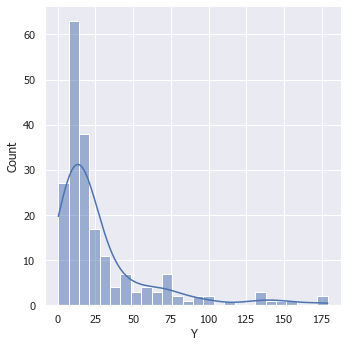

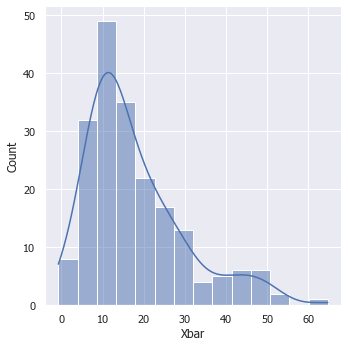

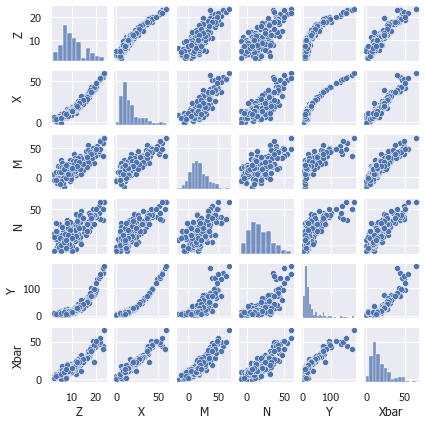

In [23]:
vis_fitted_x(stage_two_out, all_args)

In [46]:
# Stage 3
prepare_stage_3_data_and_args(all_args, stage_two_out)
compute_cme_s3_main(all_args)
compute_f_main(all_args, which_cme_Xall='cme_Xall')

Y_pred = KIV_pred(all_args.stage_3.f, 4, all_args.stage_3.cme_Xall, all_args)


1   [-3.08324296]   0.3069446050273131
2   [-3.2703756]   0.3043474960460553
3   [-3.69873614]   0.30035828768274575
4   [-4.24071893]   0.2978033522298516
5   [-4.66596767]   0.2969007653193239
6   [-5.03156122]   0.2965503823234977
7   [-5.30820126]   0.29643805754418756
8   [-5.49420791]   0.2964089978116167
Optimization terminated successfully.
         Current function value: 0.296409
         Iterations: 8
         Function evaluations: 30
         Gradient evaluations: 10
         Current function value: 1.362354
         Iterations: 0
         Function evaluations: 111
         Gradient evaluations: 33


In [51]:
%debug

> /Users/yuchenzhu/python_projects/ml/projects/measurement-error/miv/util.py(180)swap_merror_dim()
    178         obs_dims = np.arange(Xall.shape[-1]) == merror_dim
    179         new[:, merror_dim] = x.flatten()
--> 180         new[:, obs_dims] = Xall[obs_dims]
    181         return new
    182 

ipdb> Xall.shape
(1000, 3)
ipdb> exit


In [47]:
# baseline 1, use M as stand in for X
cme_Mall = compute_cme(all_args, 'M', incl_obs=True)
all_args.stage_3.cme_Mall = cme_Mall
f_M = compute_f_main(all_args, which_cme_Xall='cme_Mall')

Y_pred_M = KIV_pred(f_M, 4, cme_Mall, all_args)


# baseline 2, use N as stand in for X
cme_Nall = compute_cme(all_args, 'N', incl_obs=True)
all_args.stage_3.cme_Nall = cme_Nall
f_N = compute_f_main(all_args, which_cme_Xall='cme_Nall')

Y_pred_N = KIV_pred(f_N, 4, cme_Nall, all_args)


# baseline 3, use (M+N)/2 as stand in for X
cme_avMNall = compute_cme(all_args, 'avMN', incl_obs=True)
all_args.stage_3.cme_avMNall = cme_avMNall
f_avMN = compute_f_main(all_args, which_cme_Xall='cme_avMNall')

Y_pred_avMN = KIV_pred(f_avMN, 4, cme_avMNall, all_args)


# LVM baseline

1   [-3.19884367]   0.4343850147627132
2   [-3.67954904]   0.4319936952710415
3   [-4.08521067]   0.43106409185846856
4   [-4.42779353]   0.4307172158671348
5   [-4.66176587]   0.4306251367840663
6   [-4.78137936]   0.43061036994257185
Optimization terminated successfully.
         Current function value: 0.430610
         Iterations: 6
         Function evaluations: 27
         Gradient evaluations: 9
         Current function value: 3.733031
         Iterations: 0
         Function evaluations: 132
         Gradient evaluations: 40
1   [-3.24085385]   0.3988648198770075
2   [-3.78086346]   0.3960406406044554
3   [-4.10038228]   0.3953811790648088
4   [-4.33457342]   0.39519249312417354
5   [-4.44211051]   0.39516676621541225
Optimization terminated successfully.
         Current function value: 0.395167
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 8
1   [-2.92359091]   3.68209001202679
2   [-2.9235865]   3.68199479246229
         Current fun

In [48]:
# baseline 5, use true X 
cme__Xall = compute_cme(all_args, '_X', incl_obs=True)
print('stage 1 finished. stage 2 starts.')
all_args.stage_3.cme__Xall = cme__Xall
f__X = compute_f_main(all_args, which_cme_Xall='cme__Xall')

Y_pred__X = KIV_pred(f__X, 4, cme__Xall, all_args)

1   [-3.08368569]   0.30597527051830437
2   [-3.27188058]   0.3033577377035873
3   [-3.70363603]   0.2993701367962585
4   [-4.22359642]   0.29699196422659735
5   [-4.61034365]   0.29622457810332836
6   [-4.91286396]   0.2959701342252327
7   [-5.10575127]   0.2959094228005015
8   [-5.19928393]   0.2959005079232213
Optimization terminated successfully.
         Current function value: 0.295901
         Iterations: 8
         Function evaluations: 30
         Gradient evaluations: 10
stage 1 finished. stage 2 starts.
         Current function value: 1.348433
         Iterations: 0
         Function evaluations: 78
         Gradient evaluations: 23


In [8]:
%debug

> /Users/yuchenzhu/python_projects/ml/projects/measurement-error/miv/util.py(110)KIV_pred()
    108     W = K_X.XX @ np.linalg.inv(brac) @ K_X.Zz
    109     brac2 = make_psd(W @ W.T) + m * xi * make_psd(K_X.XX)
--> 110     alpha = np.linalg.inv(brac2) @ (W @ args.stage_1.dev.Y)
    111 
    112     K_Xtest = None

ipdb> args.keys()
f = {'K': {'ZZ': array([[1.        , 0.03957254, 0.94246034, ..., 0.74535258, 0.10429982,
        0.23143812],
       [0.03957254, 1.        , 0.01554761, ..., 0.00420268, 0.91739738,
        0.70820461],
       [0.94246034, 0.01554761, 1.        , ..., 0.91465   , 0.04727579,
        0.12103339],
       ...,
       [0.74535258, 0.00420268, 0.91465   , ..., 1.        , 0.01522922,
        0.04646829],
       [0.10429982, 0.91739738, 0.04727579, ..., 0.01522922, 1.        ,
        0.91732214],
       [0.23143812, 0.70820461, 0.12103339, ..., 0.04646829, 0.91732214,
        1.        ]]), 'Zz': array([[8.79946877e-01, 9.57515821e-01, 9.31855742e-01, ...,
   

ipdb> print(type(args))
<class 'util.dotdict'>
ipdb> print(args.keys())
dict_keys(['log_xi_0', 'xi', 'lambd_x', 'cme_X', 'n_train', 'n_dev', 'n_test', 'log_lambd_0', 'lambd_mn', 'lambd_n', 'cme_N', 'cme_MN', 'train', 'dev', 'cme__Xall'])
ipdb> exit


In [49]:
def get_psi(t):
    out = 2 * ((t - 5)**4/600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)
    return out

fy = lambda x: np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5)

# fy = lambda x: fns.sigmoid(x)
# fy = lambda x: 100 + (10 + x[:, 0]) * x[:, 2] * get_psi(x[:, 1]) - 2 * x[:, 0]


print(np.sum((Y_pred.flatten() - fy(all_args.test._Xall).flatten())**2) / Y_pred.shape[0])
print(np.sum((Y_pred_M.flatten() - fy(all_args.test._Xall).flatten())**2) / Y_pred.shape[0])
print(np.sum((Y_pred_N.flatten() - fy(all_args.test._Xall).flatten())**2) / Y_pred.shape[0])
print(np.sum((Y_pred_avMN.flatten() - fy(all_args.test._Xall).flatten())**2) / Y_pred.shape[0])
print(np.sum((Y_pred__X.flatten() - fy(all_args.test._Xall).flatten())**2) / Y_pred__X.shape[0])
print('-----comparison with the predictions of KIV which has ground truth to X; mean squared error--------')
print('ours: ', np.sum((Y_pred.flatten() - Y_pred__X.flatten())**2) / Y_pred.shape[0])
print('using M: ', np.sum((Y_pred_M.flatten() - Y_pred__X.flatten())**2) / Y_pred.shape[0])
print('using N: ', np.sum((Y_pred_N.flatten() - Y_pred__X.flatten())**2) / Y_pred.shape[0])
print('using (M+N)/2', np.sum((Y_pred_avMN.flatten() - Y_pred__X.flatten())**2) / Y_pred.shape[0])


0.13722722854120598
0.5904085498525611
0.5444231239330846
0.25431524900717184
0.12255733725785471
-----comparison with the predictions of KIV which has ground truth to X; mean squared error--------
ours:  0.006761693434633021
using M:  0.20926153743439796
using N:  0.1910174773802982
using (M+N)/2 0.05000632789282765


In [29]:
np.log10(25903)

4.413350065548239

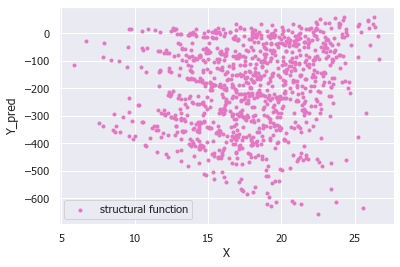

In [30]:


plt.scatter(all_args.test._X.flatten(), all_args.test.Y.flatten(), c='b', marker='.', 
            label='data')
plt.scatter(all_args.test._X.flatten(), Y_pred__X.flatten(), c='g', 
            label='KIV', marker='.' )
plt.scatter(all_args.test._X.flatten(), fy(all_args.test._Xall).flatten(), c='#e377c2', marker='.', 
            label='structural function')

# plt.scatter(all_args.test._X.flatten(), Y_pred.flatten(), c='r', marker='.', label='ours')

# plt.scatter(all_args.test._X.flatten(), Y_pred_M.flatten(), c='#17becf', 
#             label='M', marker='.' )
# plt.scatter(all_args.test._X.flatten(), Y_pred_N.flatten(), c='#bcbd22', 
#             label='N', marker='.' )
# plt.scatter(all_args.test._X.flatten(), Y_pred_avMN.flatten(), c='#7f7f7f', 
#             label='avMN', marker='.' )


plt.xlabel('X')
plt.ylabel('Y_pred')

plt.legend()




In [ ]:
all_args.stage_3.train.fitted_X[:10]
all_args.stage_1.train._X[:10]

In [35]:
print(all_args.stage_3.cme_Xall.K.Xtest[:5,:5] -  all_args.stage_3.cme__Xall.K.Xtest[:5,:5])


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [9]:
a_ = a
a_['a'] = 2
print(a)

{'a': 2}


In [38]:
cme1.K.XX[:2, :2]

array([[1.        , 0.76833797],
       [0.76833797, 1.        ]])

In [39]:
cme2.K.XX[:2, :2]

array([[1.        , 0.76833797],
       [0.76833797, 1.        ]])

### New merror implementation

In [10]:
import os
os.getcwd()

'/Users/yuchenzhu/python_projects/ml/projects/measurement-error/miv'

In [46]:
with open('../configs/MerrorKIV.yaml', 'r') as stream:
    args = yaml.safe_load(stream)

In [47]:
args.keys()
args = make_dotdict(args)
args.keys()

dict_keys(['n_repeat', 'train_params', 'data'])

In [48]:
logger = logging.getLogger()
data_config = args.data
train_params = args.train_params
verbose = 2
rand_seed = 42

trainer = MerrorKIVTrainer(data_configs=data_config, train_params=train_params)


In [49]:
train_data = generate_train_data(rand_seed=42, **data_config)
test_data = generate_test_data(**data_config)
train_1st_data, train_2nd_data = trainer.split_train_data(train_data)

# get stage1 data
N1, MN1 = train_1st_data.N, np.c_[train_1st_data.M, train_1st_data.N]
N2, MN2 = train_2nd_data.N, np.c_[train_2nd_data.M, train_2nd_data.N]
Z1 = train_1st_data.Z
Y1 = train_1st_data.Y
n = N1.shape[0]

# get stageMerror data
Z2 = train_2nd_data.Z

# get stage2 data
Y2 = train_2nd_data.Y
m = Z2.shape[0]

X_hidden is latent.

covariate0 is latent.
covariate1 is latent.
Z0 is latent.
Z1 is latent.
Z2 is latent.
M is latent.

N is latent.

Y is latent.

Y_struct is latent.



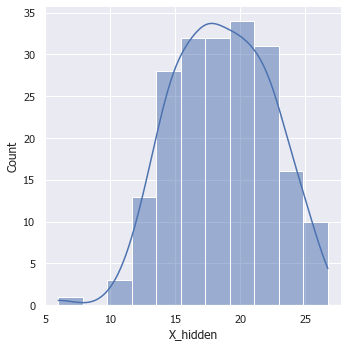

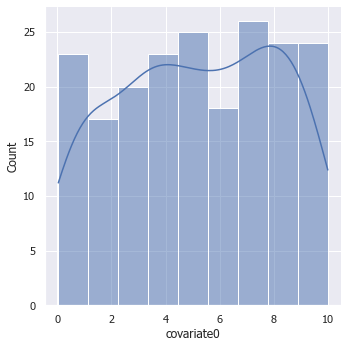

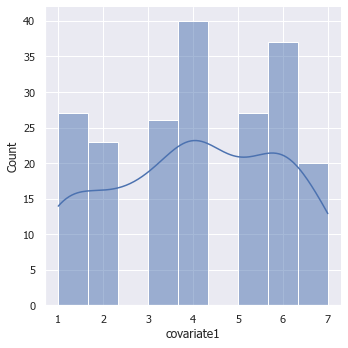

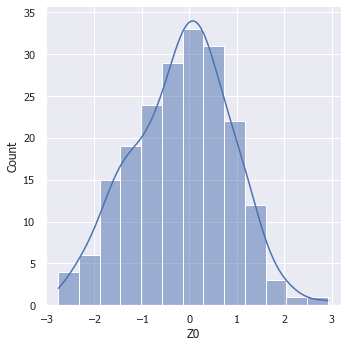

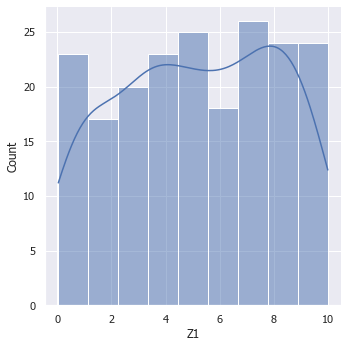

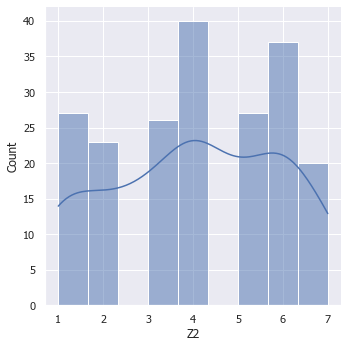

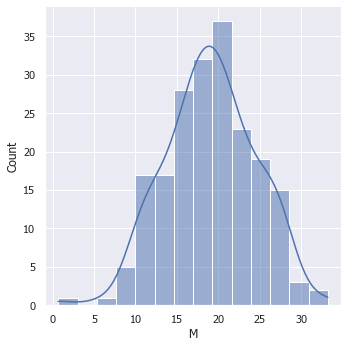

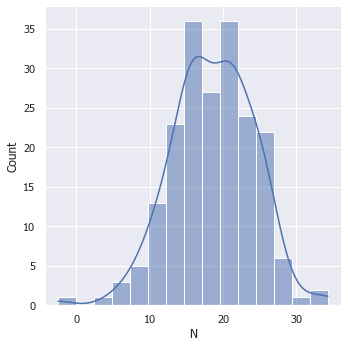

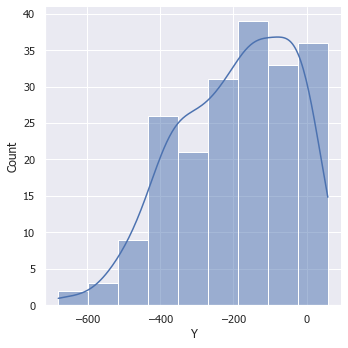

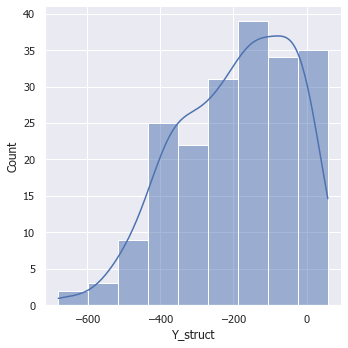

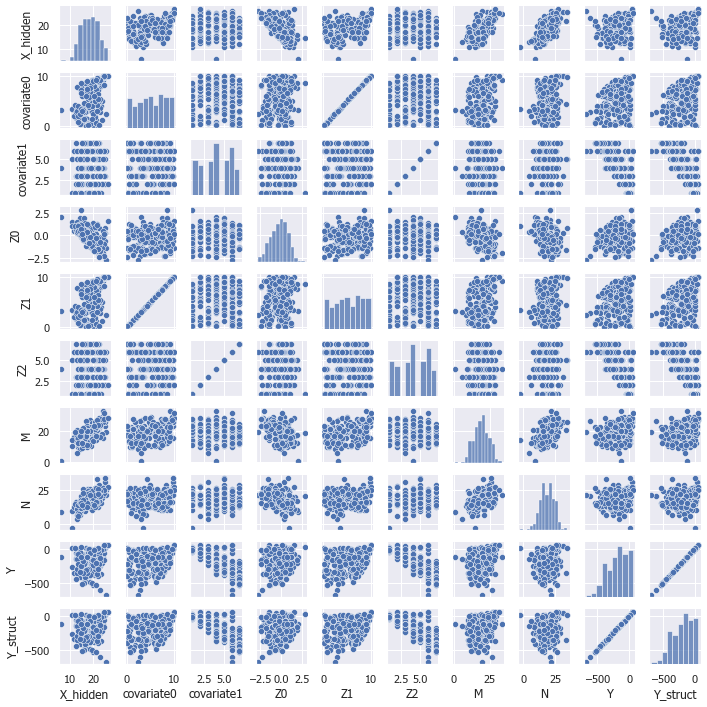

In [29]:


visualise_dataset(train_data, sample_size=200, observed_keys=[])



In [50]:
data_config

{'data_name': 'demand',
 'data_size': 2000,
 'rho': 0.5,
 'm_scale': 2.0,
 'n_scale': None,
 'bias': 0.0,
 'merror_func_str': 'gaussian'}

In [51]:
if verbose > 0:
    logger.info("start stage1")

sigmaN = get_median(N1)
sigmaMN = get_median(MN1)
sigmaZ = get_median(Z1)
KN1N1 = MerrorKIVModel.cal_gauss(N1, N1, sigmaN)
KN1N2 = MerrorKIVModel.cal_gauss(N1, N2, sigmaN)
KMN1MN1 = MerrorKIVModel.cal_gauss(MN1, MN1, sigmaMN)
KMN1MN2 = MerrorKIVModel.cal_gauss(MN1, MN2, sigmaMN)
KZ1Z1 = MerrorKIVModel.cal_gauss(Z1, Z1, sigmaZ)
KZ1Z2 = MerrorKIVModel.cal_gauss(Z1, Z2, sigmaZ)
# KX1X2 = MerrorKIVModel.cal_gauss(X1, X2, sigmaX)

if isinstance(trainer.lambda_mn, list):
    lambda_mn = np.exp(np.linspace(trainer.lambda_mn[0], trainer.lambda_mn[1], 50))
    gamma_mn, lambda_mn = trainer.stage1_tuning(KMN1MN1, KMN1MN2, KZ1Z1, KZ1Z2, lambda_mn)
    trainer.lambda_mn = lambda_mn
else:
    gamma_mn = np.linalg.solve(KZ1Z1 + n * trainer.lambda_mn * np.eye(n), KZ1Z2)

if isinstance(trainer.lambda_n, list):
    lambda_n = np.exp(np.linspace(trainer.lambda_n[0], trainer.lambda_n[1], 50))
    gamma_n, lambda_n = trainer.stage1_tuning(KN1N1, KN1N2, KZ1Z1, KZ1Z2, lambda_n)
    trainer.lambda_n = lambda_n
else:
    gamma_n = np.linalg.solve(KZ1Z1 + n * trainer.lambda_n * np.eye(n), KZ1Z2)

if verbose > 0:
    logger.info("end stage 1")
    logger.info("start stage merror")

print(lambda_n, lambda_mn, sigmaN, sigmaMN, sigmaZ)

0.004045281731274603 0.00018944182523289424 63.030589382150126 187.92257717975525 21.14082103024294


In [63]:
train_params['lambda_x'] = None
train_params['num_epochs'] = 2
train_params['lambda_x']

In [55]:
from typing import Dict, Any, Optional
from pathlib import Path
import numpy as np
import logging
from scipy.spatial.distance import cdist
# from sklearn.model_selection import train_test_split

from miv.data import generate_train_data, generate_test_data
from miv.util import dotdict, make_dotdict
from miv.data.data_class import TrainDataSet, TrainDataSetTorch, StageMDataSetTorch
from miv.models.MerrorKIV.model import MerrorKIVModel
from miv.models.MerrorKIV.stage_m_utils import create_stage_M_raw_data, prepare_stage_M_data
from miv.models.MerrorKIV.stage_m import StageMModel, stage_m_train


In [60]:
# get stageM data
M1 = train_1st_data.N
stageM_data = create_stage_M_raw_data(trainer.n_chi, N1, M1, Z2, gamma_n, gamma_mn, sigmaN, KZ1Z2)
stageM_data = prepare_stage_M_data(raw_data2=stageM_data, rand_seed=rand_seed)
stage1_MNZ = dotdict({'M': M1, 'N': N1, 'Z': Z1, 'sigmaZ': sigmaZ})

stage_m_out = trainer.stage_M_main(stageM_data=stageM_data, stage1_MNZ=stage1_MNZ, train_params=trainer.train_params)
lambda_x, fitted_x = stage_m_out.lambda_x, stage_m_out.fitted_x

fitted_X = fitted_x
if train_1st_data.X_obs is not None:
    fitted_X = np.concatenate([fitted_X, train_1st_data.X_obs], axis=-1)
if train_1st_data.covariate is not None:
    fitted_X = np.concatenate([fitted_X, train_1st_data.covariate], axis=-1)

gamma_x = np.linalg.solve(KZ1Z1 + n * lambda_x * np.eye(n), KZ1Z2)
sigmaX = get_median(fitted_X)
KfittedX = MerrorKIVModel.cal_gauss(fitted_X, fitted_X, sigmaX)
W = KfittedX.dot(gamma_x)
if verbose > 0:
    logger.info("end stageM")
    logger.info("start stage2")





first 10 M:  [[21.81841731]
 [26.6772271 ]
 [28.96565901]
 [27.40873016]
 [23.82568861]
 [14.98550329]
 [17.45058322]
 [21.68117923]
 [22.20037962]
 [26.49244102]]
first 10 N:  [[21.81841731]
 [26.6772271 ]
 [28.96565901]
 [27.40873016]
 [23.82568861]
 [14.98550329]
 [17.45058322]
 [21.68117923]
 [22.20037962]
 [26.49244102]]
first 10 initialised:  tensor([[21.8184],
        [26.6772],
        [28.9657],
        [27.4087],
        [23.8257],
        [14.9855],
        [17.4506],
        [21.6812],
        [22.2004],
        [26.4924]], dtype=torch.float64, grad_fn=<SliceBackward0>)
num train data:  253884
[epoch 1, batch     1] loss: 0.23934, mse: 0.23934, reg: 0.00000
[epoch 1, batch     2] loss: 0.25929, mse: 0.25929, reg: 0.00000
[epoch 1, batch     3] loss: 0.14877, mse: 0.14877, reg: 0.00000
[epoch 1, batch     4] loss: 0.14320, mse: 0.14320, reg: 0.00000
[epoch 1, batch     5] loss: 0.14212, mse: 0.14212, reg: 0.00000
[epoch 1, batch     6] loss: 0.06301, mse: 0.06301, reg: 0.000

[epoch 1, batch   124] loss: 0.00186, mse: 0.00186, reg: 0.00000
[epoch 1, batch   125] loss: 0.00238, mse: 0.00238, reg: 0.00000
[epoch 1, batch   126] loss: 0.00149, mse: 0.00149, reg: 0.00000
[epoch 1, batch   127] loss: 0.00143, mse: 0.00143, reg: 0.00000
[epoch 1, batch   128] loss: 0.00085, mse: 0.00085, reg: 0.00000
[epoch 1, batch   129] loss: 0.00146, mse: 0.00146, reg: 0.00000
[epoch 1, batch   130] loss: 0.00121, mse: 0.00121, reg: 0.00000
[epoch 1, batch   131] loss: 0.00251, mse: 0.00251, reg: 0.00000
[epoch 1, batch   132] loss: 0.00124, mse: 0.00124, reg: 0.00000
[epoch 1, batch   133] loss: 0.00103, mse: 0.00103, reg: 0.00000
[epoch 1, batch   134] loss: 0.00133, mse: 0.00133, reg: 0.00000
[epoch 1, batch   135] loss: 0.00113, mse: 0.00113, reg: 0.00000
[epoch 1, batch   136] loss: 0.00126, mse: 0.00126, reg: 0.00000
[epoch 1, batch   137] loss: 0.00087, mse: 0.00087, reg: 0.00000
[epoch 1, batch   138] loss: 0.00149, mse: 0.00149, reg: 0.00000
[epoch 1, batch   139] lo

[epoch 1, batch   257] loss: 0.00098, mse: 0.00098, reg: 0.00000
[epoch 1, batch   258] loss: 0.00134, mse: 0.00134, reg: 0.00000
[epoch 1, batch   259] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch   260] loss: 0.00157, mse: 0.00157, reg: 0.00000
[epoch 1, batch   261] loss: 0.00143, mse: 0.00143, reg: 0.00000
[epoch 1, batch   262] loss: 0.00100, mse: 0.00100, reg: 0.00000
[epoch 1, batch   263] loss: 0.00131, mse: 0.00131, reg: 0.00000
[epoch 1, batch   264] loss: 0.00133, mse: 0.00133, reg: 0.00000
[epoch 1, batch   265] loss: 0.00138, mse: 0.00138, reg: 0.00000
[epoch 1, batch   266] loss: 0.00097, mse: 0.00097, reg: 0.00000
[epoch 1, batch   267] loss: 0.00141, mse: 0.00141, reg: 0.00000
[epoch 1, batch   268] loss: 0.00131, mse: 0.00131, reg: 0.00000
[epoch 1, batch   269] loss: 0.00170, mse: 0.00170, reg: 0.00000
[epoch 1, batch   270] loss: 0.00143, mse: 0.00143, reg: 0.00000
[epoch 1, batch   271] loss: 0.00094, mse: 0.00094, reg: 0.00000
[epoch 1, batch   272] lo

[epoch 1, batch   390] loss: 0.00125, mse: 0.00125, reg: 0.00000
[epoch 1, batch   391] loss: 0.00119, mse: 0.00119, reg: 0.00000
[epoch 1, batch   392] loss: 0.00165, mse: 0.00165, reg: 0.00000
[epoch 1, batch   393] loss: 0.00097, mse: 0.00097, reg: 0.00000
[epoch 1, batch   394] loss: 0.00117, mse: 0.00117, reg: 0.00000
[epoch 1, batch   395] loss: 0.00106, mse: 0.00106, reg: 0.00000
[epoch 1, batch   396] loss: 0.00115, mse: 0.00115, reg: 0.00000
[epoch 1, batch   397] loss: 0.00097, mse: 0.00097, reg: 0.00000
[epoch 1, batch   398] loss: 0.00090, mse: 0.00090, reg: 0.00000
[epoch 1, batch   399] loss: 0.00234, mse: 0.00234, reg: 0.00000
[epoch 1, batch   400] loss: 0.00119, mse: 0.00119, reg: 0.00000
[epoch 1, batch   401] loss: 0.00129, mse: 0.00129, reg: 0.00000
[epoch 1, batch   402] loss: 0.00096, mse: 0.00096, reg: 0.00000
[epoch 1, batch   403] loss: 0.00141, mse: 0.00141, reg: 0.00000
[epoch 1, batch   404] loss: 0.00124, mse: 0.00124, reg: 0.00000
[epoch 1, batch   405] lo

[epoch 1, batch   523] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch   524] loss: 0.00098, mse: 0.00098, reg: 0.00000
[epoch 1, batch   525] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch   526] loss: 0.00085, mse: 0.00085, reg: 0.00000
[epoch 1, batch   527] loss: 0.00076, mse: 0.00076, reg: 0.00000
[epoch 1, batch   528] loss: 0.00073, mse: 0.00073, reg: 0.00000
[epoch 1, batch   529] loss: 0.00080, mse: 0.00080, reg: 0.00000
[epoch 1, batch   530] loss: 0.00091, mse: 0.00091, reg: 0.00000
[epoch 1, batch   531] loss: 0.00114, mse: 0.00114, reg: 0.00000
[epoch 1, batch   532] loss: 0.00124, mse: 0.00124, reg: 0.00000
[epoch 1, batch   533] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 1, batch   534] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch   535] loss: 0.00091, mse: 0.00091, reg: 0.00000
[epoch 1, batch   536] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch   537] loss: 0.00114, mse: 0.00114, reg: 0.00000
[epoch 1, batch   538] lo

[epoch 1, batch   656] loss: 0.00109, mse: 0.00109, reg: 0.00000
[epoch 1, batch   657] loss: 0.00086, mse: 0.00086, reg: 0.00000
[epoch 1, batch   658] loss: 0.00127, mse: 0.00127, reg: 0.00000
[epoch 1, batch   659] loss: 0.00110, mse: 0.00110, reg: 0.00000
[epoch 1, batch   660] loss: 0.00075, mse: 0.00075, reg: 0.00000
[epoch 1, batch   661] loss: 0.00106, mse: 0.00106, reg: 0.00000
[epoch 1, batch   662] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 1, batch   663] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch   664] loss: 0.00072, mse: 0.00072, reg: 0.00000
[epoch 1, batch   665] loss: 0.00084, mse: 0.00084, reg: 0.00000
[epoch 1, batch   666] loss: 0.00083, mse: 0.00083, reg: 0.00000
[epoch 1, batch   667] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch   668] loss: 0.00076, mse: 0.00076, reg: 0.00000
[epoch 1, batch   669] loss: 0.00078, mse: 0.00078, reg: 0.00000
[epoch 1, batch   670] loss: 0.00076, mse: 0.00076, reg: 0.00000
[epoch 1, batch   671] lo

[epoch 1, batch   789] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch   790] loss: 0.00085, mse: 0.00085, reg: 0.00000
[epoch 1, batch   791] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch   792] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 1, batch   793] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 1, batch   794] loss: 0.00109, mse: 0.00109, reg: 0.00000
[epoch 1, batch   795] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch   796] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 1, batch   797] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch   798] loss: 0.00075, mse: 0.00075, reg: 0.00000
[epoch 1, batch   799] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch   800] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch   801] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch   802] loss: 0.00071, mse: 0.00071, reg: 0.00000
[epoch 1, batch   803] loss: 0.00083, mse: 0.00083, reg: 0.00000
[epoch 1, batch   804] lo

[epoch 1, batch   922] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch   923] loss: 0.00081, mse: 0.00081, reg: 0.00000
[epoch 1, batch   924] loss: 0.00077, mse: 0.00077, reg: 0.00000
[epoch 1, batch   925] loss: 0.00075, mse: 0.00075, reg: 0.00000
[epoch 1, batch   926] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch   927] loss: 0.00103, mse: 0.00103, reg: 0.00000
[epoch 1, batch   928] loss: 0.00077, mse: 0.00077, reg: 0.00000
[epoch 1, batch   929] loss: 0.00068, mse: 0.00068, reg: 0.00000
[epoch 1, batch   930] loss: 0.00117, mse: 0.00117, reg: 0.00000
[epoch 1, batch   931] loss: 0.00089, mse: 0.00089, reg: 0.00000
[epoch 1, batch   932] loss: 0.00080, mse: 0.00080, reg: 0.00000
[epoch 1, batch   933] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch   934] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch   935] loss: 0.00085, mse: 0.00085, reg: 0.00000
[epoch 1, batch   936] loss: 0.00092, mse: 0.00092, reg: 0.00000
[epoch 1, batch   937] lo

[epoch 1, batch  1055] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  1056] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  1057] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch  1058] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 1, batch  1059] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 1, batch  1060] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 1, batch  1061] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  1062] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  1063] loss: 0.00057, mse: 0.00057, reg: 0.00000
[epoch 1, batch  1064] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch  1065] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 1, batch  1066] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  1067] loss: 0.00069, mse: 0.00069, reg: 0.00000
[epoch 1, batch  1068] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  1069] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  1070] lo

[epoch 1, batch  1188] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  1189] loss: 0.00099, mse: 0.00099, reg: 0.00000
[epoch 1, batch  1190] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 1, batch  1191] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch  1192] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  1193] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 1, batch  1194] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  1195] loss: 0.00072, mse: 0.00072, reg: 0.00000
[epoch 1, batch  1196] loss: 0.00074, mse: 0.00074, reg: 0.00000
[epoch 1, batch  1197] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 1, batch  1198] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch  1199] loss: 0.00068, mse: 0.00068, reg: 0.00000
[epoch 1, batch  1200] loss: 0.00089, mse: 0.00089, reg: 0.00000
[epoch 1, batch  1201] loss: 0.00071, mse: 0.00071, reg: 0.00000
[epoch 1, batch  1202] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  1203] lo

[epoch 1, batch  1321] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 1, batch  1322] loss: 0.00069, mse: 0.00069, reg: 0.00000
[epoch 1, batch  1323] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1324] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch  1325] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 1, batch  1326] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  1327] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  1328] loss: 0.00057, mse: 0.00057, reg: 0.00000
[epoch 1, batch  1329] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 1, batch  1330] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1331] loss: 0.00067, mse: 0.00067, reg: 0.00000
[epoch 1, batch  1332] loss: 0.00096, mse: 0.00096, reg: 0.00000
[epoch 1, batch  1333] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  1334] loss: 0.00075, mse: 0.00075, reg: 0.00000
[epoch 1, batch  1335] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  1336] lo

[epoch 1, batch  1454] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 1, batch  1455] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  1456] loss: 0.00083, mse: 0.00083, reg: 0.00000
[epoch 1, batch  1457] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch  1458] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 1, batch  1459] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 1, batch  1460] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  1461] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 1, batch  1462] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 1, batch  1463] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 1, batch  1464] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 1, batch  1465] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 1, batch  1466] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch  1467] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch  1468] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 1, batch  1469] lo

[epoch 1, batch  1587] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1588] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  1589] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  1590] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  1591] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 1, batch  1592] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  1593] loss: 0.00057, mse: 0.00057, reg: 0.00000
[epoch 1, batch  1594] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  1595] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  1596] loss: 0.00057, mse: 0.00057, reg: 0.00000
[epoch 1, batch  1597] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1598] loss: 0.00068, mse: 0.00068, reg: 0.00000
[epoch 1, batch  1599] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 1, batch  1600] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch  1601] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 1, batch  1602] lo

[epoch 1, batch  1720] loss: 0.00076, mse: 0.00076, reg: 0.00000
[epoch 1, batch  1721] loss: 0.00109, mse: 0.00109, reg: 0.00000
[epoch 1, batch  1722] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  1723] loss: 0.00085, mse: 0.00085, reg: 0.00000
[epoch 1, batch  1724] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  1725] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  1726] loss: 0.00090, mse: 0.00090, reg: 0.00000
[epoch 1, batch  1727] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1728] loss: 0.00099, mse: 0.00099, reg: 0.00000
[epoch 1, batch  1729] loss: 0.00086, mse: 0.00086, reg: 0.00000
[epoch 1, batch  1730] loss: 0.00078, mse: 0.00078, reg: 0.00000
[epoch 1, batch  1731] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  1732] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 1, batch  1733] loss: 0.00068, mse: 0.00068, reg: 0.00000
[epoch 1, batch  1734] loss: 0.00084, mse: 0.00084, reg: 0.00000
[epoch 1, batch  1735] lo

[epoch 1, batch  1853] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 1, batch  1854] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1855] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  1856] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1857] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  1858] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  1859] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  1860] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 1, batch  1861] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 1, batch  1862] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  1863] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 1, batch  1864] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 1, batch  1865] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 1, batch  1866] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  1867] loss: 0.00110, mse: 0.00110, reg: 0.00000
[epoch 1, batch  1868] lo

[epoch 1, batch  1986] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  1987] loss: 0.00072, mse: 0.00072, reg: 0.00000
[epoch 1, batch  1988] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  1989] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  1990] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch  1991] loss: 0.00067, mse: 0.00067, reg: 0.00000
[epoch 1, batch  1992] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 1, batch  1993] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 1, batch  1994] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 1, batch  1995] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  1996] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  1997] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  1998] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  1999] loss: 0.00085, mse: 0.00085, reg: 0.00000
[epoch 1, batch  2000] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 1, batch  2001] lo

[epoch 1, batch  2117] loss: 0.00067, mse: 0.00067, reg: 0.00000
[epoch 1, batch  2118] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  2119] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  2120] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  2121] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 1, batch  2122] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 1, batch  2123] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 1, batch  2124] loss: 0.00071, mse: 0.00071, reg: 0.00000
[epoch 1, batch  2125] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  2126] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 1, batch  2127] loss: 0.00071, mse: 0.00071, reg: 0.00000
[epoch 1, batch  2128] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 1, batch  2129] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  2130] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  2131] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  2132] lo

[epoch 1, batch  2250] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 1, batch  2251] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 1, batch  2252] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  2253] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  2254] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch  2255] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 1, batch  2256] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 1, batch  2257] loss: 0.00057, mse: 0.00057, reg: 0.00000
[epoch 1, batch  2258] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  2259] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 1, batch  2260] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  2261] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 1, batch  2262] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 1, batch  2263] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 1, batch  2264] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  2265] lo

[epoch 1, batch  2383] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 1, batch  2384] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  2385] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 1, batch  2386] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  2387] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch  2388] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  2389] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 1, batch  2390] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  2391] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  2392] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 1, batch  2393] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  2394] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  2395] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  2396] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  2397] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  2398] lo

[epoch 1, batch  2512] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 1, batch  2513] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  2514] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  2515] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  2516] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 1, batch  2517] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 1, batch  2518] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 1, batch  2519] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 1, batch  2520] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 1, batch  2521] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch  2522] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  2523] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch  2524] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 1, batch  2525] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  2526] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  2527] lo

[epoch 1, batch  2645] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  2646] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  2647] loss: 0.00069, mse: 0.00069, reg: 0.00000
[epoch 1, batch  2648] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 1, batch  2649] loss: 0.00136, mse: 0.00136, reg: 0.00000
[epoch 1, batch  2650] loss: 0.00073, mse: 0.00073, reg: 0.00000
[epoch 1, batch  2651] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 1, batch  2652] loss: 0.00078, mse: 0.00078, reg: 0.00000
[epoch 1, batch  2653] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 1, batch  2654] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch  2655] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  2656] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  2657] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  2658] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  2659] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  2660] lo

[epoch 1, batch  2778] loss: 0.00088, mse: 0.00088, reg: 0.00000
[epoch 1, batch  2779] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 1, batch  2780] loss: 0.00091, mse: 0.00091, reg: 0.00000
[epoch 1, batch  2781] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  2782] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 1, batch  2783] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  2784] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  2785] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 1, batch  2786] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 1, batch  2787] loss: 0.00069, mse: 0.00069, reg: 0.00000
[epoch 1, batch  2788] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  2789] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  2790] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 1, batch  2791] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 1, batch  2792] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch  2793] lo

[epoch 1, batch  2911] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 1, batch  2912] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  2913] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  2914] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  2915] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  2916] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch  2917] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  2918] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  2919] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  2920] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 1, batch  2921] loss: 0.00108, mse: 0.00108, reg: 0.00000
[epoch 1, batch  2922] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 1, batch  2923] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 1, batch  2924] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  2925] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  2926] lo

[epoch 1, batch  3044] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  3045] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 1, batch  3046] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 1, batch  3047] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  3048] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  3049] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  3050] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 1, batch  3051] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  3052] loss: 0.00084, mse: 0.00084, reg: 0.00000
[epoch 1, batch  3053] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  3054] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 1, batch  3055] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  3056] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 1, batch  3057] loss: 0.00068, mse: 0.00068, reg: 0.00000
[epoch 1, batch  3058] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  3059] lo

[epoch 1, batch  3177] loss: 0.00086, mse: 0.00086, reg: 0.00000
[epoch 1, batch  3178] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 1, batch  3179] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 1, batch  3180] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 1, batch  3181] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  3182] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  3183] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 1, batch  3184] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 1, batch  3185] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 1, batch  3186] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 1, batch  3187] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 1, batch  3188] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  3189] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  3190] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 1, batch  3191] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  3192] lo

[epoch 1, batch  3310] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 1, batch  3311] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 1, batch  3312] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  3313] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 1, batch  3314] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 1, batch  3315] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  3316] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  3317] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 1, batch  3318] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  3319] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 1, batch  3320] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 1, batch  3321] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  3322] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 1, batch  3323] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 1, batch  3324] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 1, batch  3325] lo

[epoch 1, batch  3443] loss: 0.00088, mse: 0.00088, reg: 0.00000
[epoch 1, batch  3444] loss: 0.00082, mse: 0.00082, reg: 0.00000
[epoch 1, batch  3445] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  3446] loss: 0.00071, mse: 0.00071, reg: 0.00000
[epoch 1, batch  3447] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  3448] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  3449] loss: 0.00057, mse: 0.00057, reg: 0.00000
[epoch 1, batch  3450] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  3451] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 1, batch  3452] loss: 0.00084, mse: 0.00084, reg: 0.00000
[epoch 1, batch  3453] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  3454] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  3455] loss: 0.00073, mse: 0.00073, reg: 0.00000
[epoch 1, batch  3456] loss: 0.00092, mse: 0.00092, reg: 0.00000
[epoch 1, batch  3457] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  3458] lo

[epoch 1, batch  3576] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  3577] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 1, batch  3578] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  3579] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  3580] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 1, batch  3581] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 1, batch  3582] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 1, batch  3583] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  3584] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  3585] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 1, batch  3586] loss: 0.00071, mse: 0.00071, reg: 0.00000
[epoch 1, batch  3587] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  3588] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 1, batch  3589] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 1, batch  3590] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  3591] lo

[epoch 1, batch  3709] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 1, batch  3710] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  3711] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 1, batch  3712] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 1, batch  3713] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 1, batch  3714] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  3715] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 1, batch  3716] loss: 0.00081, mse: 0.00081, reg: 0.00000
[epoch 1, batch  3717] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 1, batch  3718] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 1, batch  3719] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 1, batch  3720] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  3721] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 1, batch  3722] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 1, batch  3723] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 1, batch  3724] lo

[epoch 1, batch  3842] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 1, batch  3843] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 1, batch  3844] loss: 0.00089, mse: 0.00089, reg: 0.00000
[epoch 1, batch  3845] loss: 0.00068, mse: 0.00068, reg: 0.00000
[epoch 1, batch  3846] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 1, batch  3847] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 1, batch  3848] loss: 0.00093, mse: 0.00093, reg: 0.00000
[epoch 1, batch  3849] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 1, batch  3850] loss: 0.00090, mse: 0.00090, reg: 0.00000
[epoch 1, batch  3851] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 1, batch  3852] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 1, batch  3853] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 1, batch  3854] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 1, batch  3855] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 1, batch  3856] loss: 0.00077, mse: 0.00077, reg: 0.00000
[epoch 1, batch  3857] lo

[epoch 2, batch     6] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch     7] loss: 0.00057, mse: 0.00057, reg: 0.00000
[epoch 2, batch     8] loss: 0.00072, mse: 0.00072, reg: 0.00000
[epoch 2, batch     9] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 2, batch    10] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 2, batch    11] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch    12] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch    13] loss: 0.00074, mse: 0.00074, reg: 0.00000
[epoch 2, batch    14] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch    15] loss: 0.00074, mse: 0.00074, reg: 0.00000
[epoch 2, batch    16] loss: 0.00088, mse: 0.00088, reg: 0.00000
[epoch 2, batch    17] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch    18] loss: 0.00077, mse: 0.00077, reg: 0.00000
[epoch 2, batch    19] loss: 0.00088, mse: 0.00088, reg: 0.00000
[epoch 2, batch    20] loss: 0.00087, mse: 0.00087, reg: 0.00000
[epoch 2, batch    21] lo

[epoch 2, batch   138] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch   139] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 2, batch   140] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 2, batch   141] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch   142] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 2, batch   143] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch   144] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch   145] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 2, batch   146] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch   147] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch   148] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch   149] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch   150] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch   151] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 2, batch   152] loss: 0.00069, mse: 0.00069, reg: 0.00000
[epoch 2, batch   153] lo

[epoch 2, batch   271] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch   272] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 2, batch   273] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch   274] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch   275] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch   276] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch   277] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 2, batch   278] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch   279] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch   280] loss: 0.00067, mse: 0.00067, reg: 0.00000
[epoch 2, batch   281] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch   282] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch   283] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch   284] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch   285] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch   286] lo

[epoch 2, batch   403] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch   404] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 2, batch   405] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch   406] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch   407] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch   408] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch   409] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 2, batch   410] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 2, batch   411] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 2, batch   412] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 2, batch   413] loss: 0.00101, mse: 0.00101, reg: 0.00000
[epoch 2, batch   414] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch   415] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 2, batch   416] loss: 0.00108, mse: 0.00108, reg: 0.00000
[epoch 2, batch   417] loss: 0.00079, mse: 0.00079, reg: 0.00000
[epoch 2, batch   418] lo

[epoch 2, batch   536] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch   537] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch   538] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch   539] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch   540] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch   541] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch   542] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch   543] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch   544] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch   545] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch   546] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch   547] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch   548] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch   549] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch   550] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch   551] lo

[epoch 2, batch   669] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 2, batch   670] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch   671] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch   672] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 2, batch   673] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch   674] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch   675] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch   676] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch   677] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch   678] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch   679] loss: 0.00073, mse: 0.00073, reg: 0.00000
[epoch 2, batch   680] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch   681] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch   682] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch   683] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 2, batch   684] lo

[epoch 2, batch   800] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch   801] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch   802] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch   803] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch   804] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch   805] loss: 0.00067, mse: 0.00067, reg: 0.00000
[epoch 2, batch   806] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch   807] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch   808] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 2, batch   809] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch   810] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch   811] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch   812] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 2, batch   813] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch   814] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch   815] lo

[epoch 2, batch   933] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch   934] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch   935] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch   936] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 2, batch   937] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch   938] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch   939] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch   940] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch   941] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch   942] loss: 0.00082, mse: 0.00082, reg: 0.00000
[epoch 2, batch   943] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch   944] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch   945] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch   946] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch   947] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch   948] lo

[epoch 2, batch  1066] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 2, batch  1067] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch  1068] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch  1069] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  1070] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  1071] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  1072] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  1073] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  1074] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  1075] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  1076] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  1077] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  1078] loss: 0.00075, mse: 0.00075, reg: 0.00000
[epoch 2, batch  1079] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  1080] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  1081] lo

[epoch 2, batch  1199] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  1200] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch  1201] loss: 0.00075, mse: 0.00075, reg: 0.00000
[epoch 2, batch  1202] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 2, batch  1203] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 2, batch  1204] loss: 0.00080, mse: 0.00080, reg: 0.00000
[epoch 2, batch  1205] loss: 0.00095, mse: 0.00095, reg: 0.00000
[epoch 2, batch  1206] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 2, batch  1207] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  1208] loss: 0.00073, mse: 0.00073, reg: 0.00000
[epoch 2, batch  1209] loss: 0.00076, mse: 0.00076, reg: 0.00000
[epoch 2, batch  1210] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 2, batch  1211] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  1212] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  1213] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  1214] lo

[epoch 2, batch  1330] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch  1331] loss: 0.00019, mse: 0.00019, reg: 0.00000
[epoch 2, batch  1332] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  1333] loss: 0.00020, mse: 0.00020, reg: 0.00000
[epoch 2, batch  1334] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  1335] loss: 0.00015, mse: 0.00015, reg: 0.00000
[epoch 2, batch  1336] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  1337] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  1338] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch  1339] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  1340] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  1341] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  1342] loss: 0.00020, mse: 0.00020, reg: 0.00000
[epoch 2, batch  1343] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  1344] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  1345] lo

[epoch 2, batch  1463] loss: 0.00078, mse: 0.00078, reg: 0.00000
[epoch 2, batch  1464] loss: 0.00067, mse: 0.00067, reg: 0.00000
[epoch 2, batch  1465] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  1466] loss: 0.00107, mse: 0.00107, reg: 0.00000
[epoch 2, batch  1467] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 2, batch  1468] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  1469] loss: 0.00104, mse: 0.00104, reg: 0.00000
[epoch 2, batch  1470] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 2, batch  1471] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  1472] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  1473] loss: 0.00091, mse: 0.00091, reg: 0.00000
[epoch 2, batch  1474] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 2, batch  1475] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 2, batch  1476] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch  1477] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch  1478] lo

[epoch 2, batch  1596] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch  1597] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  1598] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  1599] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch  1600] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  1601] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  1602] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch  1603] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  1604] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 2, batch  1605] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  1606] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  1607] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  1608] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  1609] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch  1610] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  1611] lo

[epoch 2, batch  1728] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  1729] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch  1730] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  1731] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch  1732] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch  1733] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  1734] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  1735] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 2, batch  1736] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  1737] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  1738] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 2, batch  1739] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 2, batch  1740] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch  1741] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  1742] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch  1743] lo

[epoch 2, batch  1861] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  1862] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  1863] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 2, batch  1864] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  1865] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 2, batch  1866] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 2, batch  1867] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  1868] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 2, batch  1869] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 2, batch  1870] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  1871] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  1872] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  1873] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  1874] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  1875] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  1876] lo

[epoch 2, batch  1992] loss: 0.00071, mse: 0.00071, reg: 0.00000
[epoch 2, batch  1993] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 2, batch  1994] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 2, batch  1995] loss: 0.00136, mse: 0.00136, reg: 0.00000
[epoch 2, batch  1996] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  1997] loss: 0.00069, mse: 0.00069, reg: 0.00000
[epoch 2, batch  1998] loss: 0.00110, mse: 0.00110, reg: 0.00000
[epoch 2, batch  1999] loss: 0.00073, mse: 0.00073, reg: 0.00000
[epoch 2, batch  2000] loss: 0.00060, mse: 0.00060, reg: 0.00000
[epoch 2, batch  2001] loss: 0.00103, mse: 0.00103, reg: 0.00000
[epoch 2, batch  2002] loss: 0.00066, mse: 0.00066, reg: 0.00000
[epoch 2, batch  2003] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 2, batch  2004] loss: 0.00077, mse: 0.00077, reg: 0.00000
[epoch 2, batch  2005] loss: 0.00075, mse: 0.00075, reg: 0.00000
[epoch 2, batch  2006] loss: 0.00055, mse: 0.00055, reg: 0.00000
[epoch 2, batch  2007] lo

[epoch 2, batch  2125] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  2126] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  2127] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  2128] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  2129] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch  2130] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  2131] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  2132] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  2133] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  2134] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  2135] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  2136] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  2137] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  2138] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  2139] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch  2140] lo

[epoch 2, batch  2258] loss: 0.00062, mse: 0.00062, reg: 0.00000
[epoch 2, batch  2259] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 2, batch  2260] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 2, batch  2261] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  2262] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 2, batch  2263] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch  2264] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  2265] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  2266] loss: 0.00067, mse: 0.00067, reg: 0.00000
[epoch 2, batch  2267] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 2, batch  2268] loss: 0.00076, mse: 0.00076, reg: 0.00000
[epoch 2, batch  2269] loss: 0.00053, mse: 0.00053, reg: 0.00000
[epoch 2, batch  2270] loss: 0.00090, mse: 0.00090, reg: 0.00000
[epoch 2, batch  2271] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  2272] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  2273] lo

[epoch 2, batch  2391] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  2392] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch  2393] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  2394] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  2395] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  2396] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch  2397] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  2398] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 2, batch  2399] loss: 0.00020, mse: 0.00020, reg: 0.00000
[epoch 2, batch  2400] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch  2401] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  2402] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  2403] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  2404] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  2405] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  2406] lo

[epoch 2, batch  2524] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  2525] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 2, batch  2526] loss: 0.00015, mse: 0.00015, reg: 0.00000
[epoch 2, batch  2527] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  2528] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  2529] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  2530] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  2531] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  2532] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  2533] loss: 0.00019, mse: 0.00019, reg: 0.00000
[epoch 2, batch  2534] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  2535] loss: 0.00018, mse: 0.00018, reg: 0.00000
[epoch 2, batch  2536] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  2537] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  2538] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  2539] lo

[epoch 2, batch  2657] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  2658] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  2659] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  2660] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  2661] loss: 0.00044, mse: 0.00044, reg: 0.00000
[epoch 2, batch  2662] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch  2663] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  2664] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  2665] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 2, batch  2666] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  2667] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  2668] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  2669] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  2670] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  2671] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch  2672] lo

[epoch 2, batch  2790] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  2791] loss: 0.00017, mse: 0.00017, reg: 0.00000
[epoch 2, batch  2792] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  2793] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch  2794] loss: 0.00018, mse: 0.00018, reg: 0.00000
[epoch 2, batch  2795] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  2796] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  2797] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  2798] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  2799] loss: 0.00020, mse: 0.00020, reg: 0.00000
[epoch 2, batch  2800] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  2801] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  2802] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  2803] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  2804] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  2805] lo

[epoch 2, batch  2923] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch  2924] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch  2925] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  2926] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch  2927] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 2, batch  2928] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 2, batch  2929] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  2930] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 2, batch  2931] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 2, batch  2932] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 2, batch  2933] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  2934] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  2935] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch  2936] loss: 0.00049, mse: 0.00049, reg: 0.00000
[epoch 2, batch  2937] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  2938] lo

[epoch 2, batch  3056] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  3057] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  3058] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  3059] loss: 0.00036, mse: 0.00036, reg: 0.00000
[epoch 2, batch  3060] loss: 0.00019, mse: 0.00019, reg: 0.00000
[epoch 2, batch  3061] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  3062] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch  3063] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  3064] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  3065] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  3066] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  3067] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  3068] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  3069] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  3070] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  3071] lo

[epoch 2, batch  3189] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch  3190] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 2, batch  3191] loss: 0.00076, mse: 0.00076, reg: 0.00000
[epoch 2, batch  3192] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  3193] loss: 0.00073, mse: 0.00073, reg: 0.00000
[epoch 2, batch  3194] loss: 0.00063, mse: 0.00063, reg: 0.00000
[epoch 2, batch  3195] loss: 0.00047, mse: 0.00047, reg: 0.00000
[epoch 2, batch  3196] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  3197] loss: 0.00065, mse: 0.00065, reg: 0.00000
[epoch 2, batch  3198] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  3199] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  3200] loss: 0.00085, mse: 0.00085, reg: 0.00000
[epoch 2, batch  3201] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 2, batch  3202] loss: 0.00051, mse: 0.00051, reg: 0.00000
[epoch 2, batch  3203] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 2, batch  3204] lo

[epoch 2, batch  3317] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  3318] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 2, batch  3319] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  3320] loss: 0.00033, mse: 0.00033, reg: 0.00000
[epoch 2, batch  3321] loss: 0.00084, mse: 0.00084, reg: 0.00000
[epoch 2, batch  3322] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  3323] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  3324] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 2, batch  3325] loss: 0.00056, mse: 0.00056, reg: 0.00000
[epoch 2, batch  3326] loss: 0.00059, mse: 0.00059, reg: 0.00000
[epoch 2, batch  3327] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch  3328] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch  3329] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  3330] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  3331] loss: 0.00038, mse: 0.00038, reg: 0.00000
[epoch 2, batch  3332] lo

[epoch 2, batch  3450] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 2, batch  3451] loss: 0.00070, mse: 0.00070, reg: 0.00000
[epoch 2, batch  3452] loss: 0.00102, mse: 0.00102, reg: 0.00000
[epoch 2, batch  3453] loss: 0.00072, mse: 0.00072, reg: 0.00000
[epoch 2, batch  3454] loss: 0.00107, mse: 0.00107, reg: 0.00000
[epoch 2, batch  3455] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  3456] loss: 0.00064, mse: 0.00064, reg: 0.00000
[epoch 2, batch  3457] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 2, batch  3458] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  3459] loss: 0.00048, mse: 0.00048, reg: 0.00000
[epoch 2, batch  3460] loss: 0.00052, mse: 0.00052, reg: 0.00000
[epoch 2, batch  3461] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 2, batch  3462] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch  3463] loss: 0.00054, mse: 0.00054, reg: 0.00000
[epoch 2, batch  3464] loss: 0.00061, mse: 0.00061, reg: 0.00000
[epoch 2, batch  3465] lo

[epoch 2, batch  3583] loss: 0.00045, mse: 0.00045, reg: 0.00000
[epoch 2, batch  3584] loss: 0.00058, mse: 0.00058, reg: 0.00000
[epoch 2, batch  3585] loss: 0.00050, mse: 0.00050, reg: 0.00000
[epoch 2, batch  3586] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch  3587] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  3588] loss: 0.00039, mse: 0.00039, reg: 0.00000
[epoch 2, batch  3589] loss: 0.00042, mse: 0.00042, reg: 0.00000
[epoch 2, batch  3590] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  3591] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 2, batch  3592] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  3593] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  3594] loss: 0.00029, mse: 0.00029, reg: 0.00000
[epoch 2, batch  3595] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  3596] loss: 0.00015, mse: 0.00015, reg: 0.00000
[epoch 2, batch  3597] loss: 0.00040, mse: 0.00040, reg: 0.00000
[epoch 2, batch  3598] lo

[epoch 2, batch  3716] loss: 0.00017, mse: 0.00017, reg: 0.00000
[epoch 2, batch  3717] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  3718] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  3719] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch  3720] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 2, batch  3721] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  3722] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch  3723] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  3724] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  3725] loss: 0.00020, mse: 0.00020, reg: 0.00000
[epoch 2, batch  3726] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  3727] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  3728] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  3729] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  3730] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 2, batch  3731] lo

[epoch 2, batch  3849] loss: 0.00037, mse: 0.00037, reg: 0.00000
[epoch 2, batch  3850] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  3851] loss: 0.00022, mse: 0.00022, reg: 0.00000
[epoch 2, batch  3852] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  3853] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 2, batch  3854] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 2, batch  3855] loss: 0.00035, mse: 0.00035, reg: 0.00000
[epoch 2, batch  3856] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 2, batch  3857] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 2, batch  3858] loss: 0.00027, mse: 0.00027, reg: 0.00000
[epoch 2, batch  3859] loss: 0.00043, mse: 0.00043, reg: 0.00000
[epoch 2, batch  3860] loss: 0.00046, mse: 0.00046, reg: 0.00000
[epoch 2, batch  3861] loss: 0.00026, mse: 0.00026, reg: 0.00000
[epoch 2, batch  3862] loss: 0.00041, mse: 0.00041, reg: 0.00000
[epoch 2, batch  3863] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 2, batch  3864] lo

[epoch 3, batch     8] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 3, batch     9] loss: 0.00018, mse: 0.00018, reg: 0.00000
[epoch 3, batch    10] loss: 0.00011, mse: 0.00011, reg: 0.00000
[epoch 3, batch    11] loss: 0.00025, mse: 0.00025, reg: 0.00000
[epoch 3, batch    12] loss: 0.00023, mse: 0.00023, reg: 0.00000
[epoch 3, batch    13] loss: 0.00031, mse: 0.00031, reg: 0.00000
[epoch 3, batch    14] loss: 0.00020, mse: 0.00020, reg: 0.00000
[epoch 3, batch    15] loss: 0.00019, mse: 0.00019, reg: 0.00000
[epoch 3, batch    16] loss: 0.00021, mse: 0.00021, reg: 0.00000
[epoch 3, batch    17] loss: 0.00032, mse: 0.00032, reg: 0.00000
[epoch 3, batch    18] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 3, batch    19] loss: 0.00024, mse: 0.00024, reg: 0.00000
[epoch 3, batch    20] loss: 0.00030, mse: 0.00030, reg: 0.00000
[epoch 3, batch    21] loss: 0.00034, mse: 0.00034, reg: 0.00000
[epoch 3, batch    22] loss: 0.00028, mse: 0.00028, reg: 0.00000
[epoch 3, batch    23] lo

In [61]:
stage_m_out.lambda_x

0.0004

1.9835448124274293
2.0057152744209787
2.037509574170811
1.4018534064171186


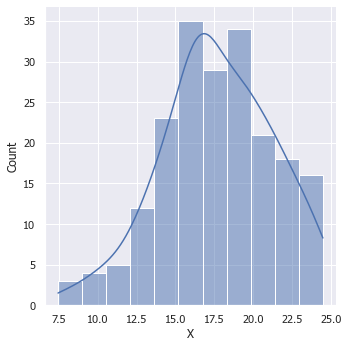

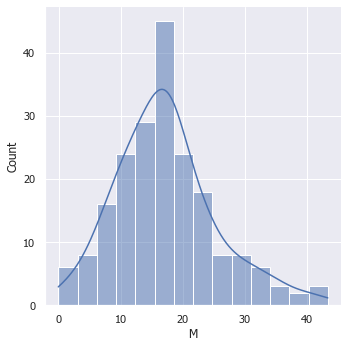

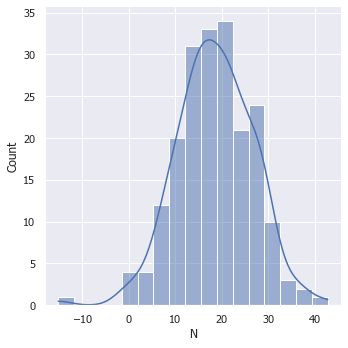

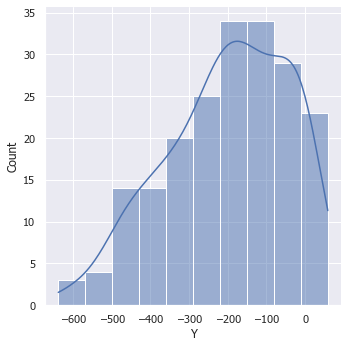

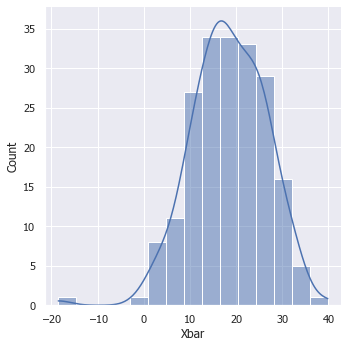

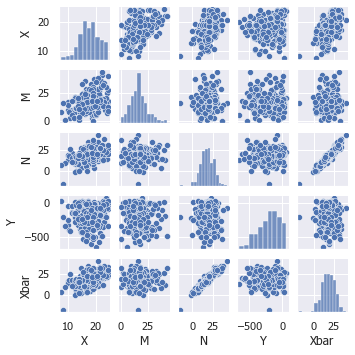

In [62]:
def vis_fitted_x_new(stage_two_out, train_data):
    fitted_X = stage_two_out.fitted_x
    print((np.sum((fitted_X - train_1st_data.X_hidden)**2) / fitted_X.shape[0])**0.5 / np.std(train_1st_data.X_hidden))
    print((np.sum((train_1st_data.N - train_1st_data.X_hidden)**2) / fitted_X.shape[0])**0.5 / np.std(train_1st_data.X_hidden))
    print((np.sum((train_1st_data.M - train_1st_data.X_hidden)**2) / fitted_X.shape[0])**0.5 / np.std(train_1st_data.X_hidden))
    print((np.sum((1/2 * train_1st_data.M + 1/2 * train_1st_data.N - train_1st_data.X_hidden)**2) / fitted_X.shape[0])**0.5 / np.std(train_1st_data.X_hidden))

    # plotting
    sample_size = 200

    D = pd.DataFrame([train_1st_data.X_hidden[:sample_size].flatten(), 
                      train_1st_data.M[:sample_size].flatten(), 
                      train_1st_data.N[:sample_size].flatten(), 
                      train_1st_data.Y[:sample_size].flatten(), 
                      fitted_X[:sample_size].flatten()]).T
    D.columns = ['X','M', 'N', 'Y', 'Xbar']

    ecorr_v = D.corr()
    ecorr_v.columns = ['X','M', 'N', 'Y', 'Xbar']

    for v in ['X','M', 'N', 'Y', 'Xbar']:
        sns.displot(D, x=v, label=v, kde=True), plt.show()

    sns.set_theme(font="tahoma", font_scale=1)
    plt.show()

    sns.pairplot(D, height=1) 
    plt.show()
    
vis_fitted_x_new(stage_m_out, train_data)


In [48]:
%debug

> <ipython-input-47-8d47ba508268>(3)vis_fitted_x_new()
      1 def vis_fitted_x_new(stage_two_out, train_data):
      2     fitted_X = stage_two_out.fitted_X
----> 3     print((np.sum((fitted_X - train_data.X_hidden)**2) / fitted_X.shape[0])**0.5 / np.std(train_data.X_hidden))
      4     print((np.sum((train_data.N- train_data.X_hidden)**2) / fitted_X.shape[0])**0.5 / np.std(train_data.X_hidden))
      5     print((np.sum((train_data.M - train_data.X_hidden)**2) / fitted_X.shape[0])**0.5 / np.std(train_data.X_hidden))

ipdb> fitted_X
ipdb> stage_two_out.keys()
dict_keys(['fitted_x', 'lambda_x'])
ipdb> exit


In [ ]:
if isinstance(self.xi, list):
    # breakpoint()
    self.xi = np.exp(np.linspace(self.xi[0], self.xi[1], 50))
    alpha, xi = self.stage2_tuning(W, KfittedX, Y1, Y2)
    self.xi = xi
else:
    alpha = np.linalg.solve(W.dot(W.T) + m * self.xi * KfittedX, W.dot(Y2))

if verbose > 0:
    logger.info("end stage2")

mdl = MerrorKIVModel(fitted_X=fitted_X, alpha=alpha, sigma=sigmaX)

test_error = mdl.evaluate(test_data=test_data)

print('xi')
visualise final learnt structural function

### debug

In [15]:
from miv.models.MerrorKIV.trainer import get_median
from miv.util import get_median_inter_mnist
from designs import datasets
# set data
dt = datasets.HLLT  # NP, custom1, HLLT
raw_sim=dt
all_args = fill_in_args('../configs/kernel.yaml')

prepare_pre_stage_1_args_and_data(all_args, raw_sim)
prepare_stage_1_data_and_args(all_args)

MN = np.concatenate([all_args.stage_1.train.M, all_args.stage_1.train.N], axis=-1)
N = all_args.stage_1.train.N
Z = all_args.stage_1.train.Z
X = all_args.stage_1.train._X

print(get_median(N))
print(get_median_inter_mnist(N)**2)
print(np.std(X))
print(X.shape)
print(all_args.stage_1.train.keys())

# "N 26.129797285627593 MN 74.52897587690816 Z 21.101863364131773"

106.03757588133377
106.03757588100248
3.8068680610196606
(1000, 1)
dict_keys(['Z', 'M', 'N', '_X', '_U', 'Y', '_Xall'])


In [29]:
from miv.util import compute_rbf_kernel

sigmasqN = get_median(MN1)
sigmaN = get_median_inter_mnist(MN1)
KN1N1dfiv = MerrorKIVModel.cal_gauss(MN1, MN2, sigmasqN)
KN1N1kiv = compute_rbf_kernel(MN1, MN2, sigmaN)
print(np.max(np.abs(KN1N1dfiv - KN1N1kiv)))


4.8931803053875456e-11


In [ ]:
"""## debug
from miv.models.MerrorKIV.stage_m import StageMModel
from miv.models.MerrorKIV.trainer import get_median
with open('../configs/MerrorKIV.yaml', 'r') as stream:
    args = yaml.safe_load(stream)
train_params = args['train_params']
print(train_params)
stageM_data = all_args.stage_2.train
print(stageM_data.keys())
stage1_MNZ = dotdict({'M': all_args.stage_1.train.M, 'N': all_args.stage_1.train.N, 'Z': all_args.stage_1.train.Z, 'sigmaZ': get_median(all_args.stage_1.train.Z)})
model_new = StageMModel(stageM_data=stageM_data, train_params=make_dotdict(train_params), stage1_MNZ=stage1_MNZ)
"""

In [27]:
def get_x(z, u, N_data):
    # t = HLLT_.ft(N_data)
    # s = HLLT_.fs(N_data)
    c = z[:, 0].reshape(-1,1)
    t = z[:, 1].reshape(-1,1)
    s = z[:, 2].reshape(-1,1)
    p = 25 + (c+3)*get_psi(t) + u

    return np.concatenate([p, t, s], axis=-1)

def get_z(N_data):
    c = np.random.normal(0, 1, HLLT_.N_data).reshape(-1,1)
    t = HLLT_.ft(N_data)
    s = HLLT_.fs(N_data)
    # breakpoint()
    return np.concatenate([c, t, s], axis=-1)


def get_psi(t):
    out = 2 * ((t - 5)**4/600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)
    return out

HLLT_ = dotdict({
    'name': 'HLLT',
    'N_data': 10000,
    'noise_level': 2.,
    'noise_level_merror': 10.,
    'obs_dim': [1, 2],
    'merror_dim': 0,  # can only do 1 merror dim right now.
    'discrete_xdims': [2],
    'bias': 0.,
    'rho': 0.5
})
HLLT_ = dotdict(HLLT_)
# HLLT_.fz = lambda: np.random.normal(0, 1, HLLT_.N_data).reshape(-1,1)
# HLLT_.fv = lambda N_data: np.random.normal(0, 1, HLLT_.N_data).reshape(-1,1)  # this is u
HLLT_.fs = lambda N_data: np.random.choice(7, HLLT_.N_data).reshape(-1,1) + 1
HLLT_.ft = lambda N_data: np.random.uniform(0, 1, HLLT_.N_data).reshape(-1,1) * 10

HLLT_.fu = lambda N_data: np.random.normal(0, 1, HLLT_.N_data).reshape(-1,1)
# HLLT_.fz = lambda N_data: np.random.normal(0, 1, HLLT_.N_data).reshape(-1,1)
HLLT_.fz = lambda N_data: get_z(N_data)
HLLT_.fx = lambda z, u, N_data: get_x(z, u, N_data)
HLLT_.fm = lambda x, N_data: np.reshape(x[:, HLLT_.merror_dim] + HLLT_.noise_level_merror * np.random.normal(0, 1, N_data), newshape=(-1, 1))
HLLT_.fn = lambda x, N_data: np.reshape(x[:, HLLT_.merror_dim] + HLLT_.noise_level_merror * np.random.normal(0, 1, N_data) + HLLT_.bias, newshape=(-1, 1))
HLLT_.fy = lambda x, u, N_data: np.reshape(100 + (10 + x[:, 0]) * x[:, 2] * get_psi(x[:, 1]) - 2 * x[:, 0] \
                                + np.random.normal(HLLT_.rho * u, np.sqrt(1 - HLLT_.rho ** 2), HLLT_.N_data), newshape=(-1,1))
HLLT_.ydox = lambda x: 100 + (10 + x[:, 0]) * x[:, 2] * get_psi(x[:, 1]) - 2 * x[:, 0]


In [ ]:
def psi(t: np.ndarray) -> np.ndarray:
    out = 2 * ((t - 5) ** 4 / 600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)
    return out


def f(p: np.ndarray, t: np.ndarray, s: np.ndarray) -> np.ndarray:
    return 100 + (10 + p) * s * psi(t) - 2 * p


def generate_train_demand_design(data_size: int,
                                 rho: float,
                                 merror_func_str: str,
                                 m_scale: float,
                                 n_scale: float,
                                 bias: float,
                                 rand_seed: int = 42) -> TrainDataSet:
    """

    Parameters
    ----------
    data_size : int
        size of data
    rho : float
        parameter for confounding
    merror_func_str: str
        parameter for choosing a measurement error mechanism
    m_scale: float
        chooses the error spread in M
    n_scale: float
        chooses the error spread in N
    bias: float
        chooses the bias level in N
    rand_seed : int
        random seed


    Returns
    -------
    train_data : TrainDataSet
    """
    merror_func = get_merror_func(merror_func_str)
    rng = default_rng(seed=rand_seed)
    emotion = rng.choice(list(range(1, 8)), data_size)
    time = rng.uniform(0, 10, data_size)
    cost = rng.normal(0, 1.0, data_size)
    noise_price = rng.normal(0, 1.0, data_size)
    noise_demand = rho * noise_price + rng.normal(0, np.sqrt(1 - rho ** 2), data_size)
    price = 25 + (cost + 3) * psi(time) + noise_price

    structure: np.ndarray = f(price, time, emotion).astype(float)
    outcome: np.ndarray = (structure + noise_demand).astype(float)

    X_hidden = price[:, np.newaxis]
    X_obs = None
    covariate = np.c_[time, emotion]
    M, N = merror_func(X_hidden=X_hidden, scale_m=m_scale, scale_n=n_scale, bias=bias)
    Z = np.c_[cost, time, emotion]

    train_data = TrainDataSet(X_hidden=X_hidden,
                              X_obs=X_obs,
                              covariate=covariate,
                              M=M,
                              N=N,
                              Z=Z,
                              Y_struct=structure[:, np.newaxis],
                              Y=outcome[:, np.newaxis])

    return train_data

In [ ]:
## debug
from miv.models.MerrorKIV.stage_m import StageMModel
from miv.models.MerrorKIV.trainer import get_median
from miv.models.MerrorKIV.stage_m import stage_m_train
from miv.util import make_dotdict

with open('../configs/MerrorKIV.yaml', 'r') as stream:
    args = yaml.safe_load(stream)
train_params = make_dotdict(args['train_params'])
print('train_params: ', train_params)
stageM_data = all_args.stage_2.train

print('stageM labels: ', stageM_data.labels[:10])
print(stageM_data.keys())
stage1_MNZ = dotdict({'M': all_args.stage_1.train.M, 'N': all_args.stage_1.train.N, 'Z': all_args.stage_1.train.Z, 'sigmaZ': get_median(all_args.stage_1.train.Z)})
model_new = StageMModel(stageM_data=stageM_data, train_params=make_dotdict(train_params), stage1_MNZ=stage1_MNZ)

start = time.time()
model_new = stage_m_train(model_new, stageM_data=stageM_data, stageM_args=train_params)
end = time.time()

print('time used for {} epochs: {}'.format(train_params['num_epochs'], end - start))
